In [1]:
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

In [2]:
# Define a colors

blue = (0, 92/255, 171/255, 1)
red = (227/255, 27/255, 35/255, 1)
orange = (1, 195/255, 37/255, 1)
green = (30/255, 170/255, 30/255, 1)

In [3]:
def str_to_list(string):
    
    return [float(x) for x in string[1:-1].split(',')]

In [4]:
def get_val_metric(row):
    
    metrics = row['validation_metrics']
    keys = metrics[1:-1].split('\'')[1::2]
    list_values = [str_to_list(x[2:-2]) for x in metrics[1:-1].split('\'')[0::2][1:]]

    validation_metrics = {
        key: values for key, values in zip(keys, list_values)
    }

    validation_metric = validation_metrics[list(validation_metrics.keys())[0]]
    
    return validation_metric

# Slides

## Full vs BitFit vs LayerNorm

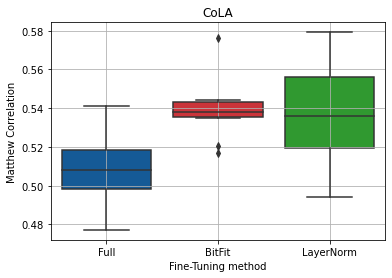

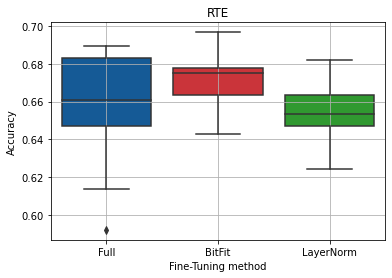

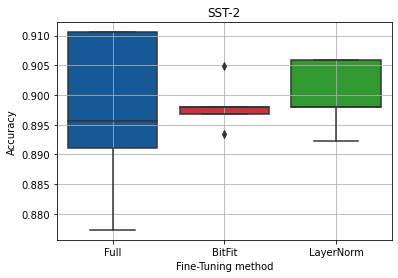

In [5]:
df = pd.read_csv('results_df.csv')

df = df[(df['Finetuning'].isin(['Full', 'BitFit', 'LayerNorm'])) & (df['subsample_train_size']=='All')]
df = df[df['dataset_name'].isin(['CoLA', 'RTE', 'SST-2'])]

LayerNorm_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 5e-4,
    'QNLI': 5e-4
}

BitFit_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 1e-4,
    'QNLI': 5e-4
}

for data in ['CoLA', 'RTE', 'SST-2']:
    df = df[((df['dataset_name'] == data) & (df['lr'] == BitFit_lrs[data]) & (df['Finetuning']=='BitFit')) |
           ((df['dataset_name']!=data) | (df['Finetuning']!='BitFit'))]
    df = df[((df['dataset_name'] == data) & (df['lr'] == LayerNorm_lrs[data]) & (df['Finetuning']=='LayerNorm')) |
           ((df['dataset_name']!=data) | (df['Finetuning']!='LayerNorm'))]

plt.rcParams.update({'font.size': 10})
palette = {'Full': blue, 'BitFit': red, 'LayerNorm': green}

# CoLA
sns.boxplot(data = df[df['dataset_name']=='CoLA'], x = 'Finetuning', y = 'eval_metric',
            order = ['Full', 'BitFit', 'LayerNorm'], palette = palette)
plt.xlabel('Fine-Tuning method')
plt.ylabel('Matthew Correlation')
plt.title('CoLA')
plt.grid()
plt.savefig('figures_slides/CoLA_AllMethods.png', format = 'png', bbox_inches = 'tight', dpi = 400)
plt.show()

# RTE
sns.boxplot(data = df[df['dataset_name']=='RTE'], x = 'Finetuning', y = 'eval_metric', 
            order = ['Full', 'BitFit', 'LayerNorm'], palette = palette)
plt.xlabel('Fine-Tuning method')
plt.ylabel('Accuracy')
plt.title('RTE')
plt.grid()
plt.savefig('figures_slides/RTE_AllMethods.png', format = 'png', bbox_inches = 'tight', dpi = 400)
plt.show()

# SST-2
sns.boxplot(data = df[df['dataset_name']=='SST-2'], x = 'Finetuning', y = 'eval_metric',
            order = ['Full', 'BitFit', 'LayerNorm'], palette = palette)
plt.xlabel('Fine-Tuning method')
plt.ylabel('Accuracy')
plt.title('SST-2')
plt.grid()
plt.savefig('figures_slides/SST-2_AllMethods.png', format = 'png', bbox_inches = 'tight', dpi = 400)
plt.show()

## Low Data Regime

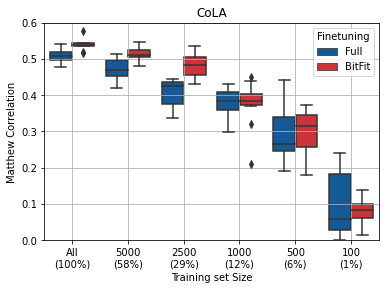

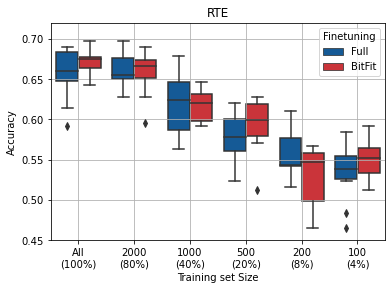

In [6]:
df = pd.read_csv('results_df.csv')

BitFit_lr = 5e-4

boxplot = True
    
for dataset_name, dataset_size in zip(['CoLA', 'RTE'], [8551, 2490]):
    
    if dataset_name == 'CoLA':
        ylim = [0.0, 0.6]
        metric = 'Matthew Correlation'
    else:
        ylim = [0.45, 0.72]
        metric = 'Accuracy'

    df2 = df[df['dataset_name'] == dataset_name]
    df2 = df2[(df2['Finetuning'] == 'Full') | ((df2['Finetuning'] == 'BitFit') & (df2['lr'] == BitFit_lr))]

    sizes = list(np.sort([int(x) for x in df2['subsample_train_size'].unique() if x != 'All']))

    ticks = [x/dataset_size for x in sizes]
    ticks = [str(num) + "\n({:.0f}%)".format(perc*100) for perc, num in zip(ticks, sizes)]
    ticks.append('All\n(100%)')
    ticks = ticks[::-1]

    sizes.append('All')
    order = [str(x) for x in sizes][::-1]

    hue_order = ['Full', 'BitFit']

    palette = {'Full': blue, 'BitFit': red}
    
    if boxplot:
        sns.boxplot(data = df2, x = 'subsample_train_size', y = 'eval_metric', hue = 'Finetuning',
                    order = order, hue_order = hue_order, palette = palette)
    else:
        sns.barplot(data = df2, x = 'subsample_train_size', y = 'eval_metric', hue = 'Finetuning',
                    order = order, hue_order = hue_order, palette=palette)
        
    plt.grid()
    #plt.title(dataset_name)
    plt.xlabel('Training set Size')
    plt.ylabel(metric)
    plt.title(dataset_name)
    plt.ylim(ylim)
    plt.xticks([0,1,2,3,4,5], ticks)

    plt.savefig('figures_slides/'+'DiffSize' + dataset_name + '.png', format = 'png', bbox_inches = 'tight', dpi = 400)

    plt.show()

## Losses Full vs BitFit vs LayerNorm

In [7]:
df = pd.read_csv('results_df.csv')

df = df[df['subsample_train_size']=='All']

datasets = ['CoLA', 'SST-2']

FTS = ['Full', 'BitFit', 'LayerNorm']

BitFit_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 1e-4,
    'QNLI': 5e-4
}

Random_lrs = {
    'CoLA': 1e-3,
    'RTE': 5e-3,
    'SST-2': 1e-3
}

LayerNorm_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 5e-4,
    'QNLI': 5e-4
}

InitBias_BitFit_lrs = {
    'CoLA': 1e-3,
    'RTE': 1e-4,
    'SST-2': 5e-4
}

df = df[(df['dataset_name'].isin(datasets)) & (df['Finetuning'].isin(FTS))]

for dataset in datasets:
    
    if dataset in list(BitFit_lrs.keys()):

        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'BitFit') & (df['lr'] == BitFit_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'BitFit'))]
    if dataset in list(Random_lrs.keys()):  
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'Random') & (df['lr'] == Random_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'Random'))]
    if dataset in list(LayerNorm_lrs.keys()):  
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'LayerNorm') & (df['lr'] == LayerNorm_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'LayerNorm'))]
    if dataset in list(InitBias_BitFit_lrs.keys()):  
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'InitBias&BitFit') & (df['lr'] == InitBias_BitFit_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'InitBias&BitFit'))]

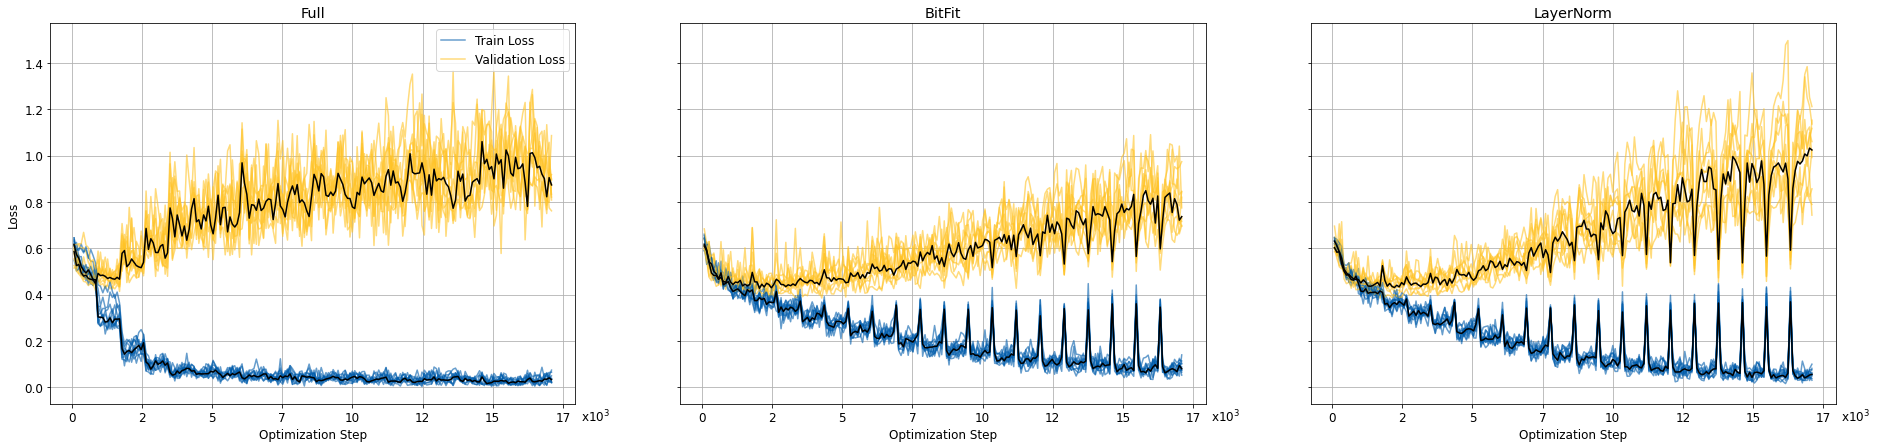

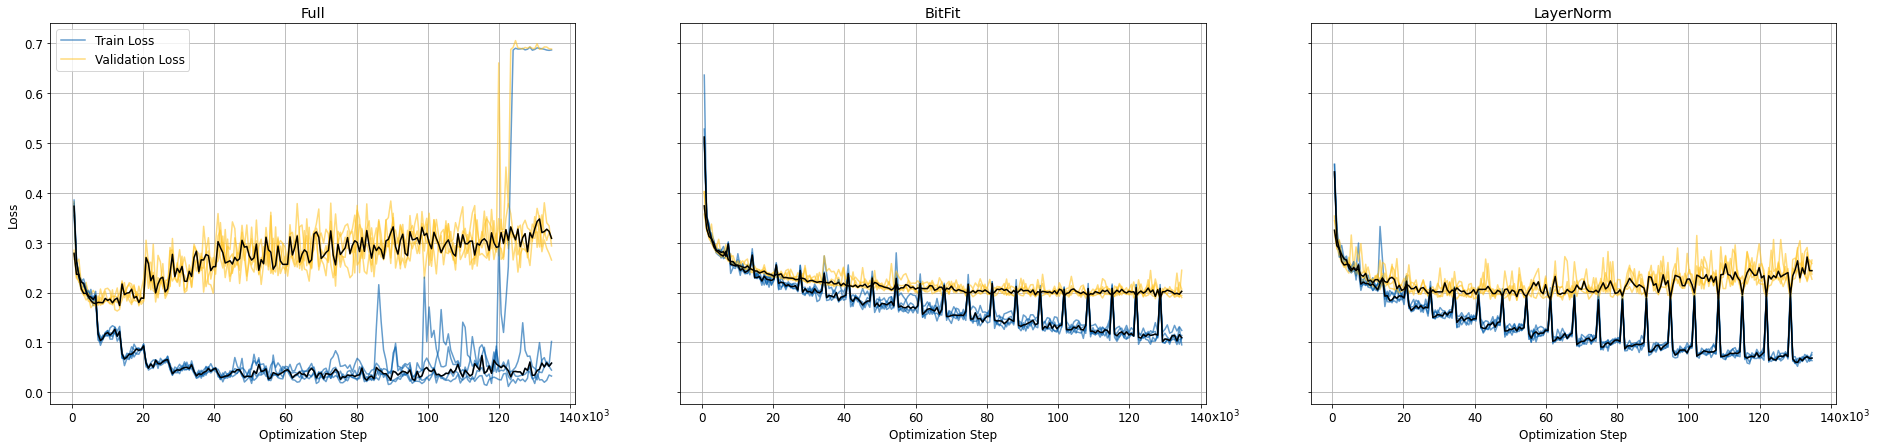

In [8]:
plt.rcParams.update({'font.size': 12})
for dataset in datasets:
    
    fig, axs = plt.subplots(1, len(FTS), figsize = (32,7), sharey = True, sharex = True)
    
    for i, FT in enumerate(FTS):
        
        ax = axs[i]
        
        df1 = df[(df['dataset_name']==dataset) & (df['Finetuning']==FT)]
        
        if len(df1) == 0:
            continue
            
        median_train = [str_to_list(x.train_loss) for _, x in df1.iterrows()]
        median_train = torch.Tensor(median_train).median(dim = 0).values.tolist()
        median_val = [str_to_list(x.validation_loss) for _, x in df1.iterrows()]
        median_val = torch.Tensor(median_val).median(dim = 0).values.tolist()

        steps = str_to_list(df1.iloc[0]['steps'])

        for i in range(len(df1)):

            steps = str_to_list(df1.iloc[i]['steps'])
            train_loss = str_to_list(df1.iloc[i]['train_loss'])
            val_loss = str_to_list(df1.iloc[i]['validation_loss'])

            ax.plot(steps, train_loss, color = blue, alpha = 0.6)
            ax.plot(steps, val_loss, color = orange, alpha = 0.6)
            
        if FT == 'Full':
            ax.legend(['Train Loss', 'Validation Loss'])
            ax.set_ylabel('Loss')

        ax.plot(steps, median_train, color = 'k')
        ax.plot(steps, median_val, color = 'k')
        
        if FT == 'InitBias&BitFit':
            FT = FT.replace('&', '+')
        ax.set_title(FT)
        ax.set_xlabel('Optimization Step')
        ax.grid()
        
        ax.annotate('x$10^3$', xy=(1.01, -0.01), ha='left', va='top', xycoords='axes fraction')
        
    ticks = [str(int(x / 1000)) for x in plt.xticks()[0]][1:-1]
    ticks_loc = plt.xticks()[0][1:-1]
    plt.xticks(ticks_loc, ticks)
    
    plt.savefig('figures_slides/'+dataset+'Losses' + dataset + '.png', format = 'png', bbox_inches = 'tight', dpi = 400)
        
    plt.show()

## Metrics Full vs BitFit vs LayerNorm

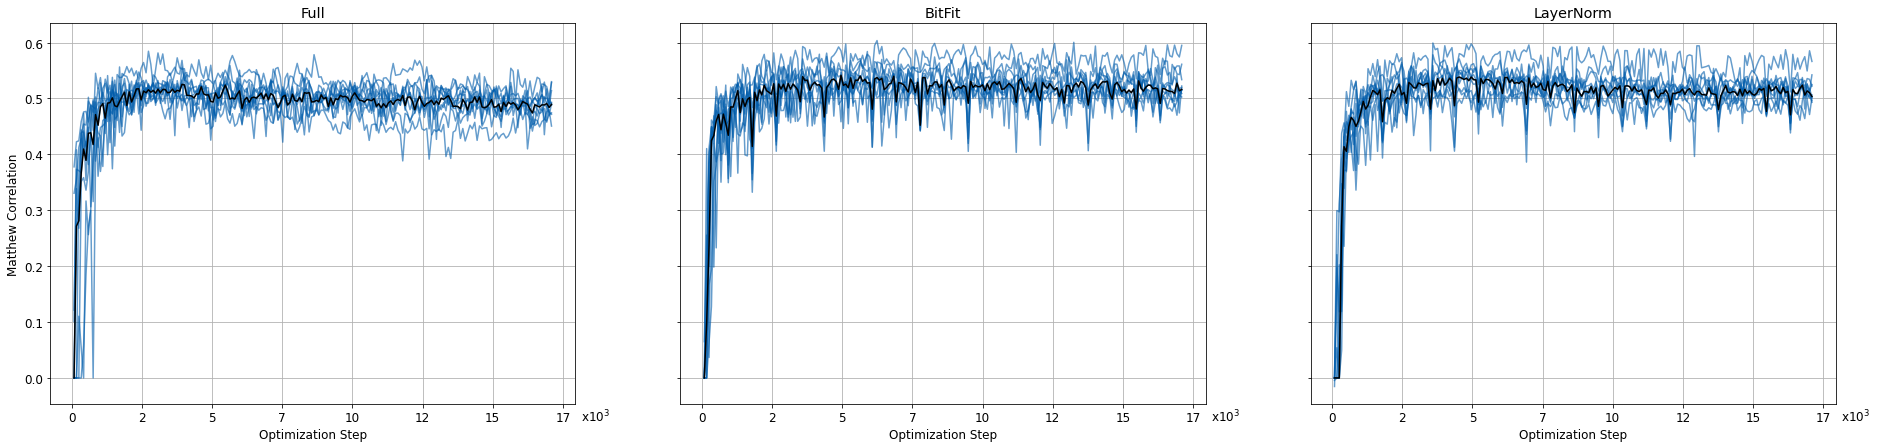

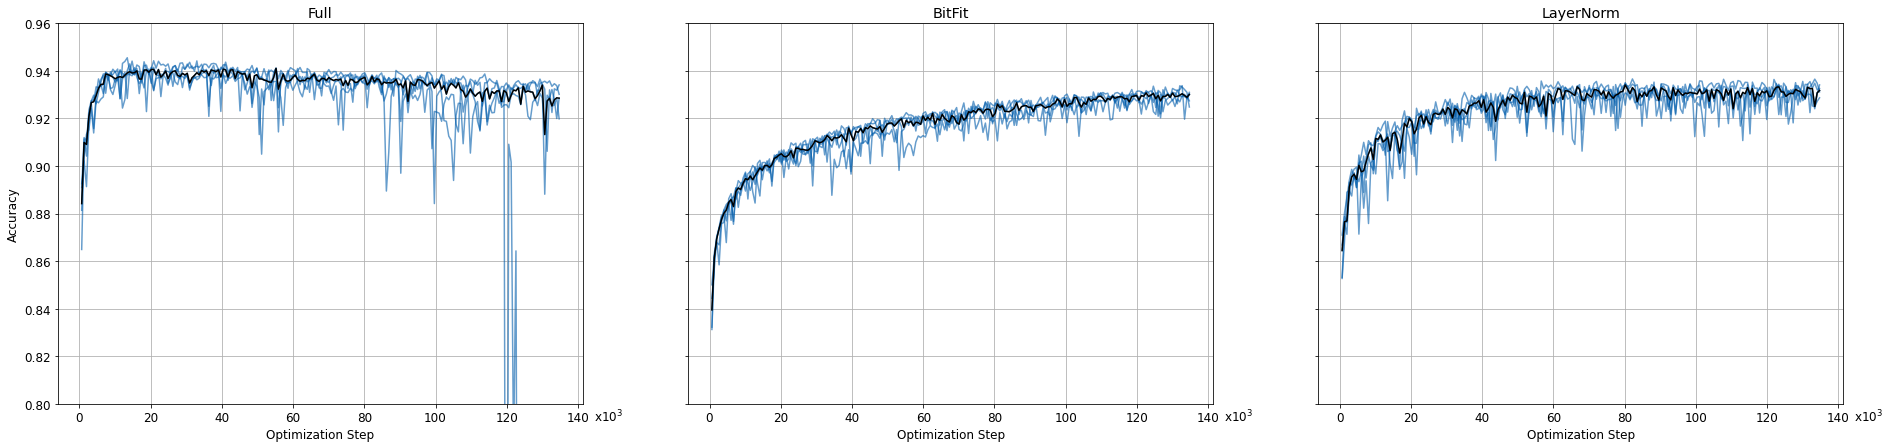

In [9]:
plt.rcParams.update({'font.size': 12})
for dataset in datasets:
    fig, axs = plt.subplots(1,len(FTS), figsize = (32,7), sharex = True, sharey = True)
    for j, FT in enumerate(FTS):
        
        ax = axs[j]
        
        df1 = df[(df['dataset_name']==dataset) & (df['Finetuning'] == FT)]
        
        if len(df1) == 0:
            continue
        
        median = torch.Tensor([get_val_metric(row) for i, row in df1.iterrows()]).median(dim = 0).values.tolist()

        for i in range(len(df1)):
            steps = str_to_list(df1.iloc[i].steps)
            validation_metric = get_val_metric(df1.iloc[i])
            ax.plot(steps, validation_metric, color = blue, alpha = 0.6)

        ax.plot(steps, median, color = 'k')
        
        if dataset == 'CoLA':
            ax.annotate('x$10^3$', xy=(1.01, -0.01), ha='left', va='top', xycoords='axes fraction')
        else:
            ax.annotate('x$10^3$', xy=(1.02, -0.01), ha='left', va='top', xycoords='axes fraction')
            
        
        if FT == 'InitBias&BitFit':
            FT = FT.replace('&', '+')
        ax.set_title(FT)
        
        if dataset == 'CoLA' and FT == 'Full':
            ax.set_ylabel('Matthew Correlation')
        elif dataset != 'CoLA' and FT == 'Full':
            ax.set_ylabel('Accuracy')
        ax.set_xlabel('Optimization Step')
        if dataset == 'SST-2':
            plt.ylim([0.8, 0.96])
        
        ax.grid()
        
    ticks = [str(int(x / 1000)) for x in plt.xticks()[0]][1:-1]
    ticks_loc = plt.xticks()[0][1:-1]
    plt.xticks(ticks_loc, ticks)
    
    plt.savefig('figures_slides/'+dataset+'ValMetrics.png', format = 'png', bbox_inches = 'tight', dpi = 400)
    
    plt.show()

## Random Full vs BitFit vs Random

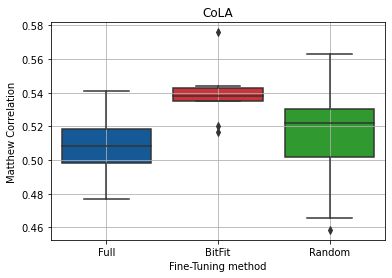

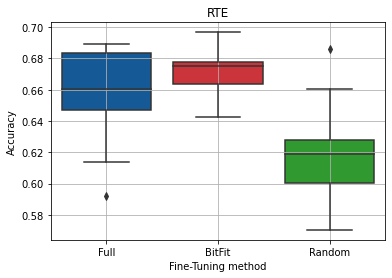

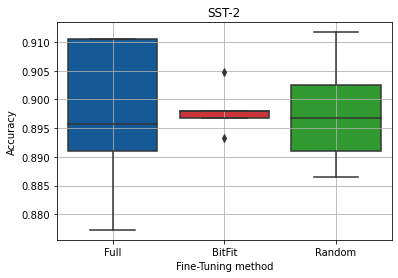

In [10]:
df = pd.read_csv('results_df.csv')

df = df[(df['Finetuning'].isin(['Full', 'BitFit', 'Random'])) & (df['subsample_train_size']=='All')]
df = df[df['dataset_name'].isin(['CoLA', 'RTE', 'SST-2'])]

LayerNorm_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 5e-4,
    'QNLI': 5e-4
}

BitFit_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 1e-4,
    'QNLI': 5e-4
}

Random_lrs = {
    'CoLA': 1e-3,
    'RTE': 5e-3,
    'SST-2': 1e-3
}

for data in ['CoLA', 'RTE', 'SST-2']:
    df = df[((df['dataset_name'] == data) & (df['lr'] == BitFit_lrs[data]) & (df['Finetuning']=='BitFit')) |
           ((df['dataset_name']!=data) | (df['Finetuning']!='BitFit'))]
    df = df[((df['dataset_name'] == data) & (df['lr'] == LayerNorm_lrs[data]) & (df['Finetuning']=='LayerNorm')) |
           ((df['dataset_name']!=data) | (df['Finetuning']!='LayerNorm'))]

plt.rcParams.update({'font.size': 10})
palette = {'Full': blue, 'BitFit': red, 'Random': green}

# CoLA
sns.boxplot(data = df[df['dataset_name']=='CoLA'], x = 'Finetuning', y = 'eval_metric',
            order = ['Full', 'BitFit', 'Random'], palette = palette)
plt.xlabel('Fine-Tuning method')
plt.ylabel('Matthew Correlation')
plt.title('CoLA')
plt.grid()
plt.savefig('figures_slides/CoLA_Random.png', format = 'png', bbox_inches = 'tight', dpi = 400)
plt.show()

# RTE
sns.boxplot(data = df[df['dataset_name']=='RTE'], x = 'Finetuning', y = 'eval_metric', 
            order = ['Full', 'BitFit', 'Random'], palette = palette)
plt.xlabel('Fine-Tuning method')
plt.ylabel('Accuracy')
plt.title('RTE')
plt.grid()
plt.savefig('figures_slides/RTE_Random.png', format = 'png', bbox_inches = 'tight', dpi = 400)
plt.show()

# SST-2
sns.boxplot(data = df[df['dataset_name']=='SST-2'], x = 'Finetuning', y = 'eval_metric',
            order = ['Full', 'BitFit', 'Random'], palette = palette)
plt.xlabel('Fine-Tuning method')
plt.ylabel('Accuracy')
plt.title('SST-2')
plt.grid()
plt.savefig('figures_slides/SST-2_Random.png', format = 'png', bbox_inches = 'tight', dpi = 400)
plt.show()

## Random Losses Full vs BitFit vs Random

In [11]:
df = pd.read_csv('results_df.csv')

df = df[df['subsample_train_size']=='All']

datasets = ['CoLA']

FTS = ['Full', 'BitFit', 'Random']

BitFit_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 1e-4,
    'QNLI': 5e-4
}

Random_lrs = {
    'CoLA': 1e-3,
    'RTE': 5e-3,
    'SST-2': 1e-3
}

LayerNorm_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 5e-4,
    'QNLI': 5e-4
}

InitBias_BitFit_lrs = {
    'CoLA': 1e-3,
    'RTE': 1e-4,
    'SST-2': 5e-4
}

df = df[(df['dataset_name'].isin(datasets)) & (df['Finetuning'].isin(FTS))]

for dataset in datasets:
    
    if dataset in list(BitFit_lrs.keys()):

        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'BitFit') & (df['lr'] == BitFit_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'BitFit'))]
    if dataset in list(Random_lrs.keys()):  
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'Random') & (df['lr'] == Random_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'Random'))]
    if dataset in list(LayerNorm_lrs.keys()):  
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'LayerNorm') & (df['lr'] == LayerNorm_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'LayerNorm'))]
    if dataset in list(InitBias_BitFit_lrs.keys()):  
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'InitBias&BitFit') & (df['lr'] == InitBias_BitFit_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'InitBias&BitFit'))]

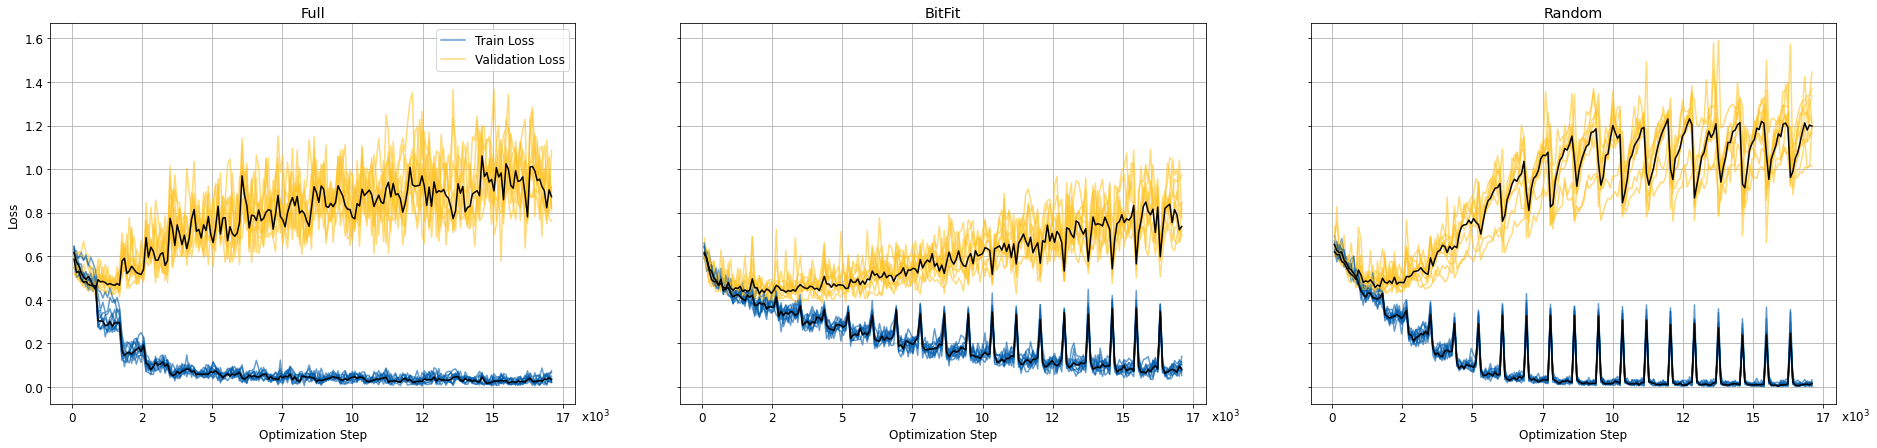

In [12]:
plt.rcParams.update({'font.size': 12})
for dataset in datasets:
    
    fig, axs = plt.subplots(1, len(FTS), figsize = (32,7), sharey = True, sharex = True)
    
    for i, FT in enumerate(FTS):
        
        ax = axs[i]
        
        df1 = df[(df['dataset_name']==dataset) & (df['Finetuning']==FT)]
        
        if len(df1) == 0:
            continue
            
        median_train = [str_to_list(x.train_loss) for _, x in df1.iterrows()]
        median_train = torch.Tensor(median_train).median(dim = 0).values.tolist()
        median_val = [str_to_list(x.validation_loss) for _, x in df1.iterrows()]
        median_val = torch.Tensor(median_val).median(dim = 0).values.tolist()

        steps = str_to_list(df1.iloc[0]['steps'])

        for i in range(len(df1)):

            steps = str_to_list(df1.iloc[i]['steps'])
            train_loss = str_to_list(df1.iloc[i]['train_loss'])
            val_loss = str_to_list(df1.iloc[i]['validation_loss'])

            ax.plot(steps, train_loss, color = blue, alpha = 0.6)
            ax.plot(steps, val_loss, color = orange, alpha = 0.6)
            
        if FT == 'Full':
            ax.legend(['Train Loss', 'Validation Loss'])
            ax.set_ylabel('Loss')

        ax.plot(steps, median_train, color = 'k')
        ax.plot(steps, median_val, color = 'k')
        
        if FT == 'InitBias&BitFit':
            FT = FT.replace('&', '+')
        ax.set_title(FT)
        ax.set_xlabel('Optimization Step')
        ax.grid()
        
        ax.annotate('x$10^3$', xy=(1.01, -0.01), ha='left', va='top', xycoords='axes fraction')
        
    ticks = [str(int(x / 1000)) for x in plt.xticks()[0]][1:-1]
    ticks_loc = plt.xticks()[0][1:-1]
    plt.xticks(ticks_loc, ticks)
    
    plt.savefig('figures_slides/RandomLosses' + dataset + '.png', format = 'png', bbox_inches = 'tight', dpi = 400)
        
    plt.show()

In [13]:
df = pd.read_csv('results_df.csv')

df = df[df['subsample_train_size']=='All']

datasets = ['RTE', 'SST-2']

FTS = ['Full', 'BitFit', 'Random']

BitFit_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 1e-4,
    'QNLI': 5e-4
}

Random_lrs = {
    'CoLA': 1e-3,
    'RTE': 5e-3,
    'SST-2': 1e-3
}

LayerNorm_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 5e-4,
    'QNLI': 5e-4
}

InitBias_BitFit_lrs = {
    'CoLA': 1e-3,
    'RTE': 1e-4,
    'SST-2': 5e-4
}

df = df[(df['dataset_name'].isin(datasets)) & (df['Finetuning'].isin(FTS))]

for dataset in datasets:
    
    if dataset in list(BitFit_lrs.keys()):

        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'BitFit') & (df['lr'] == BitFit_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'BitFit'))]
    if dataset in list(Random_lrs.keys()):  
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'Random') & (df['lr'] == Random_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'Random'))]
    if dataset in list(LayerNorm_lrs.keys()):  
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'LayerNorm') & (df['lr'] == LayerNorm_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'LayerNorm'))]
    if dataset in list(InitBias_BitFit_lrs.keys()):  
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'InitBias&BitFit') & (df['lr'] == InitBias_BitFit_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'InitBias&BitFit'))]

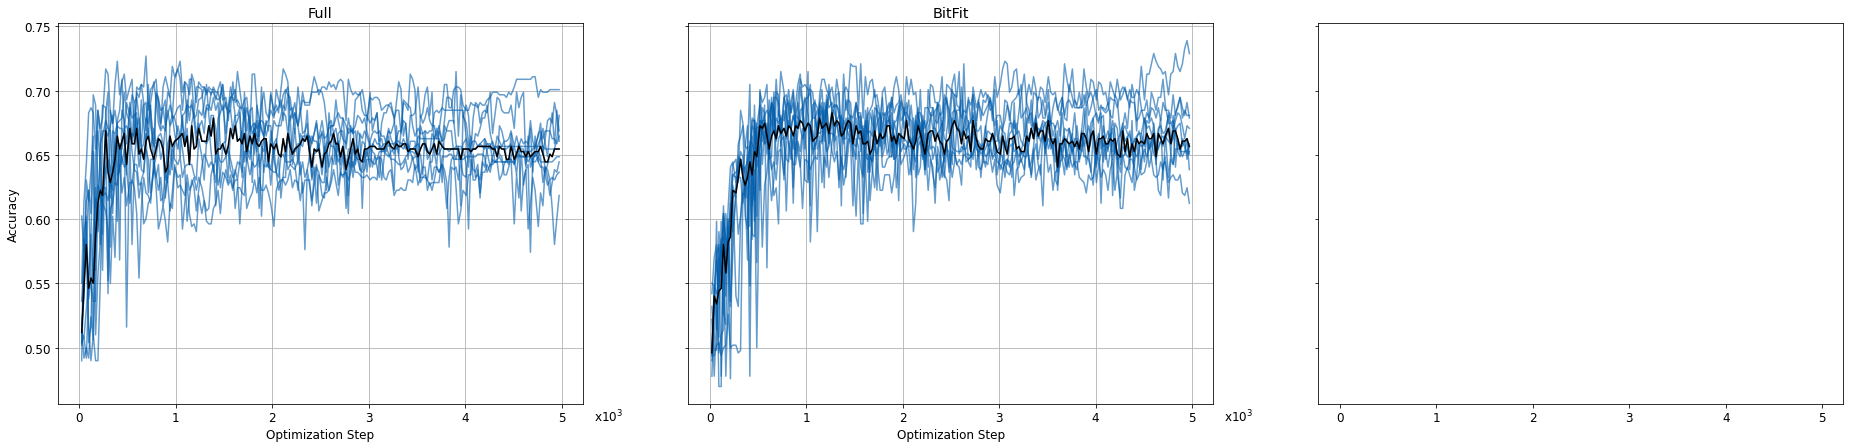

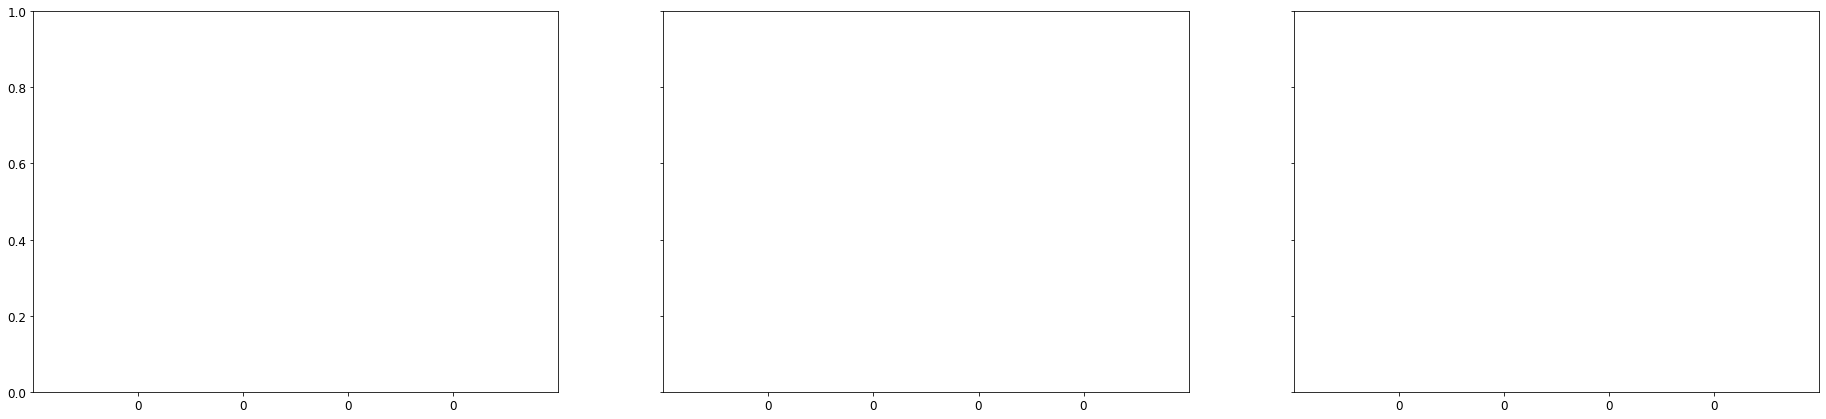

In [14]:
plt.rcParams.update({'font.size': 12})
for dataset in datasets:
    fig, axs = plt.subplots(1,len(FTS), figsize = (32,7), sharex = True, sharey = True)
    for j, FT in enumerate(FTS):
        
        ax = axs[j]
        
        df1 = df[(df['dataset_name']==dataset) & (df['Finetuning'] == FT)]
        
        if len(df1) == 0:
            continue
        
        median = torch.Tensor([get_val_metric(row) for i, row in df1.iterrows()]).median(dim = 0).values.tolist()

        for i in range(len(df1)):
            steps = str_to_list(df1.iloc[i].steps)
            validation_metric = get_val_metric(df1.iloc[i])
            ax.plot(steps, validation_metric, color = blue, alpha = 0.6)

        ax.plot(steps, median, color = 'k')
        
        if dataset == 'CoLA':
            ax.annotate('x$10^3$', xy=(1.01, -0.01), ha='left', va='top', xycoords='axes fraction')
        else:
            ax.annotate('x$10^3$', xy=(1.02, -0.01), ha='left', va='top', xycoords='axes fraction')
            
        
        if FT == 'InitBias&BitFit':
            FT = FT.replace('&', '+')
        ax.set_title(FT)
        
        if dataset == 'CoLA' and FT == 'Full':
            ax.set_ylabel('Matthew Correlation')
        elif dataset != 'CoLA' and FT == 'Full':
            ax.set_ylabel('Accuracy')
        ax.set_xlabel('Optimization Step')
        if dataset == 'SST-2':
            plt.ylim([0.8, 0.96])
        
        ax.grid()
        
    ticks = [str(int(x / 1000)) for x in plt.xticks()[0]][1:-1]
    ticks_loc = plt.xticks()[0][1:-1]
    plt.xticks(ticks_loc, ticks)
    
    plt.savefig('figures_slides/'+dataset+'RandomValMetrics.png', format = 'png', bbox_inches = 'tight', dpi = 400)
    
    plt.show()

## Init + BitFit

### See ExtractResults for BitFit on CoLA with all parameters reinitialized

In [15]:
df = pd.read_csv('results_df.csv')

df = df[df['subsample_train_size']=='All']

datasets = ['CoLA', 'RTE', 'SST-2']

FTS = ['Full', 'BitFit', 'InitBias&BitFit']

BitFit_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 1e-4,
    'QNLI': 5e-4
}

Random_lrs = {
    'CoLA': 1e-3,
    'RTE': 5e-3,
    'SST-2': 1e-3
}

LayerNorm_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 5e-4,
    'QNLI': 5e-4
}

InitBias_BitFit_lrs = {
    'CoLA': 1e-3,
    'RTE': 1e-4,
    'SST-2': 5e-4
}

df = df[(df['dataset_name'].isin(datasets)) & (df['Finetuning'].isin(FTS))]

for dataset in datasets:
    
    if dataset in list(BitFit_lrs.keys()):

        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'BitFit') & (df['lr'] == BitFit_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'BitFit'))]
    if dataset in list(Random_lrs.keys()):  
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'Random') & (df['lr'] == Random_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'Random'))]
    if dataset in list(LayerNorm_lrs.keys()):  
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'LayerNorm') & (df['lr'] == LayerNorm_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'LayerNorm'))]
    if dataset in list(InitBias_BitFit_lrs.keys()):  
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'InitBias&BitFit') & (df['lr'] == InitBias_BitFit_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'InitBias&BitFit'))]

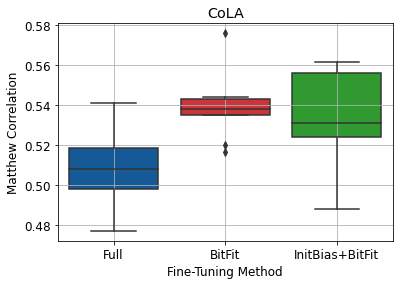

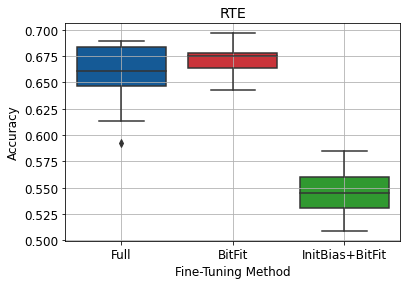

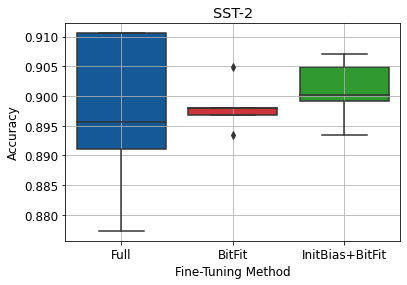

In [16]:
palette = {'Full': blue, 'BitFit': red, 'InitBias+BitFit': green}
for dataset in datasets:
    order = ['Full', 'BitFit', 'InitBias+BitFit']
    df['Finetuning'] = df['Finetuning'].apply(lambda x: x.replace('&', '+') if x == 'InitBias&BitFit' else x)
    sns.boxplot(data = df[(df['dataset_name'] == dataset) & (df['eval_metric']>0.2)], x = 'Finetuning', y = 'eval_metric',
               order = order, palette = palette)
    plt.grid()
    plt.xlabel('Fine-Tuning Method')
    if dataset == 'CoLA':
        plt.ylabel('Matthew Correlation')
    else:
        plt.ylabel('Accuracy')
    plt.title(dataset)
    
    plt.savefig('figures_slides/InitBias' + dataset + 'Boxplots.png', format = 'png', bbox_inches = 'tight', dpi = 400)
    
    plt.show()

CoLA InitBias&BitFit
RTE InitBias&BitFit
SST-2 InitBias&BitFit


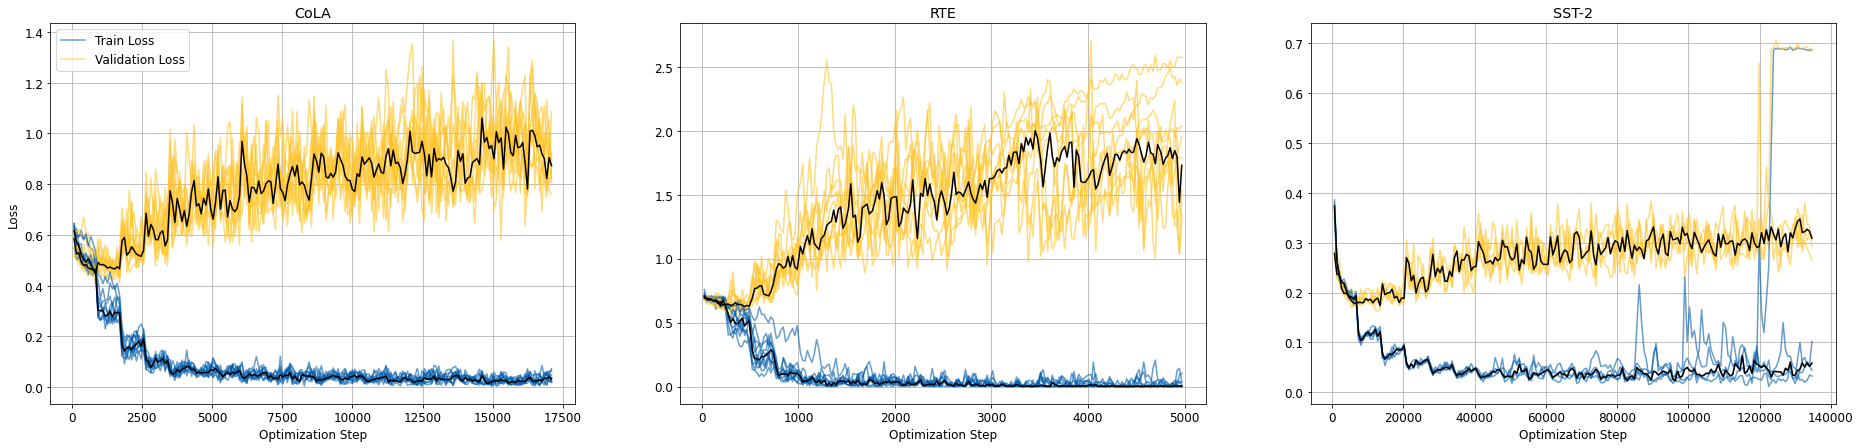

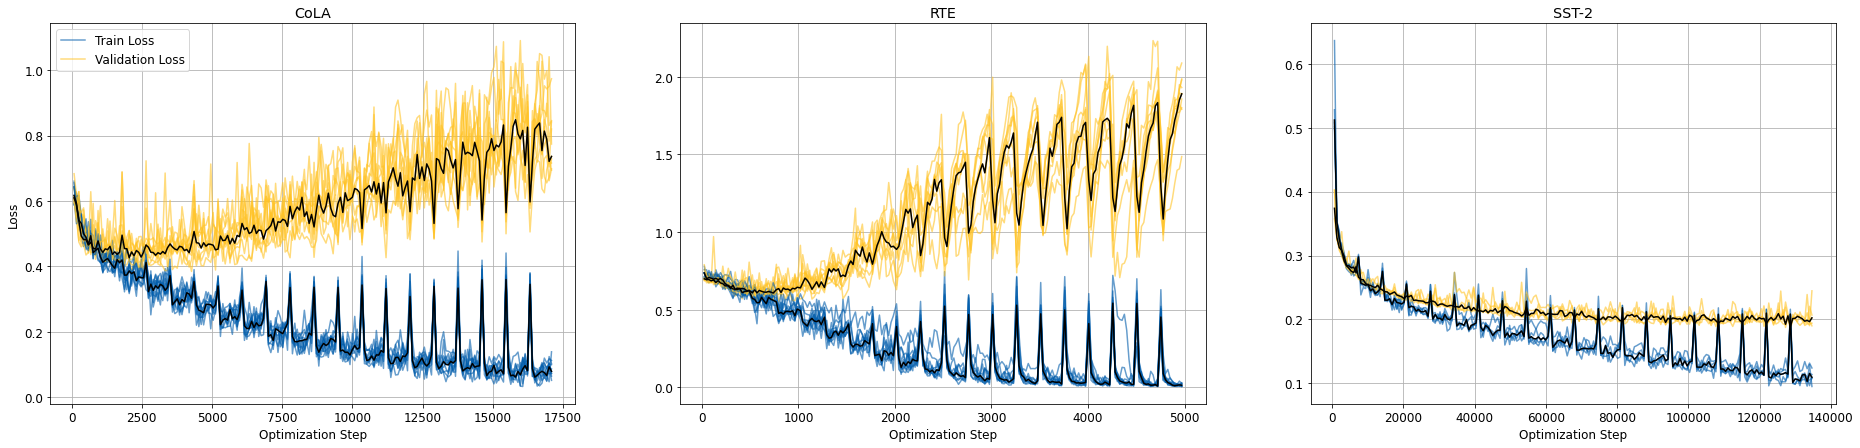

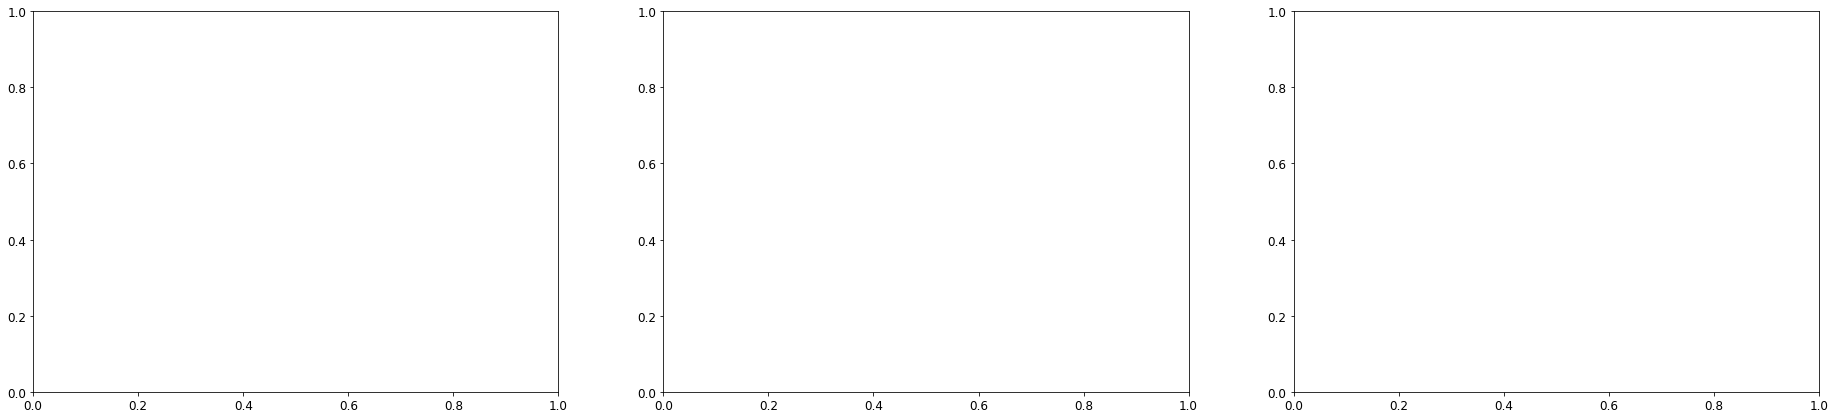

In [17]:
plt.rcParams.update({'font.size': 12})

for FT in FTS:
    
    fig, axs = plt.subplots(1, len(datasets), figsize = (32,7))
    
    for i, dataset in enumerate(datasets):
        
        ax = axs[i]
        
        df1 = df[(df['dataset_name']==dataset) & (df['Finetuning']==FT)]
        
        if len(df1) == 0:
            print(dataset, FT)
            continue
            
        median_train = [str_to_list(x.train_loss) for _, x in df1.iterrows()]
        median_train = torch.Tensor(median_train).median(dim = 0).values.tolist()
        median_val = [str_to_list(x.validation_loss) for _, x in df1.iterrows()]
        median_val = torch.Tensor(median_val).median(dim = 0).values.tolist()

        steps = str_to_list(df1.iloc[0]['steps'])

        for i in range(len(df1)):

            steps = str_to_list(df1.iloc[i]['steps'])
            train_loss = str_to_list(df1.iloc[i]['train_loss'])
            val_loss = str_to_list(df1.iloc[i]['validation_loss'])

            ax.plot(steps, train_loss, color = blue, alpha = 0.6)
            ax.plot(steps, val_loss, color = orange, alpha = 0.6)
            
        if dataset == 'CoLA':
            ax.legend(['Train Loss', 'Validation Loss'])
            ax.set_ylabel('Loss')

        ax.plot(steps, median_train, color = 'k')
        ax.plot(steps, median_val, color = 'k')
        
        #if FT == 'InitBias&BitFit':
        #    FT = FT.replace('&', '+')
        ax.set_title(dataset)
        ax.set_xlabel('Optimization Step')
        ax.grid()
        
        #ax.annotate('x$10^3$', xy=(1.01, -0.01), ha='left', va='top', xycoords='axes fraction')
        
        ticks = [str(int(x / 1000)) for x in plt.xticks()[0]][1:-1]
        ticks_loc = plt.xticks()[0][1:-1]
        #plt.xticks(ticks_loc, ticks)
    
plt.savefig('figures_slides/InitBiasLosses.png', format = 'png', bbox_inches = 'tight', dpi = 400)

plt.show()

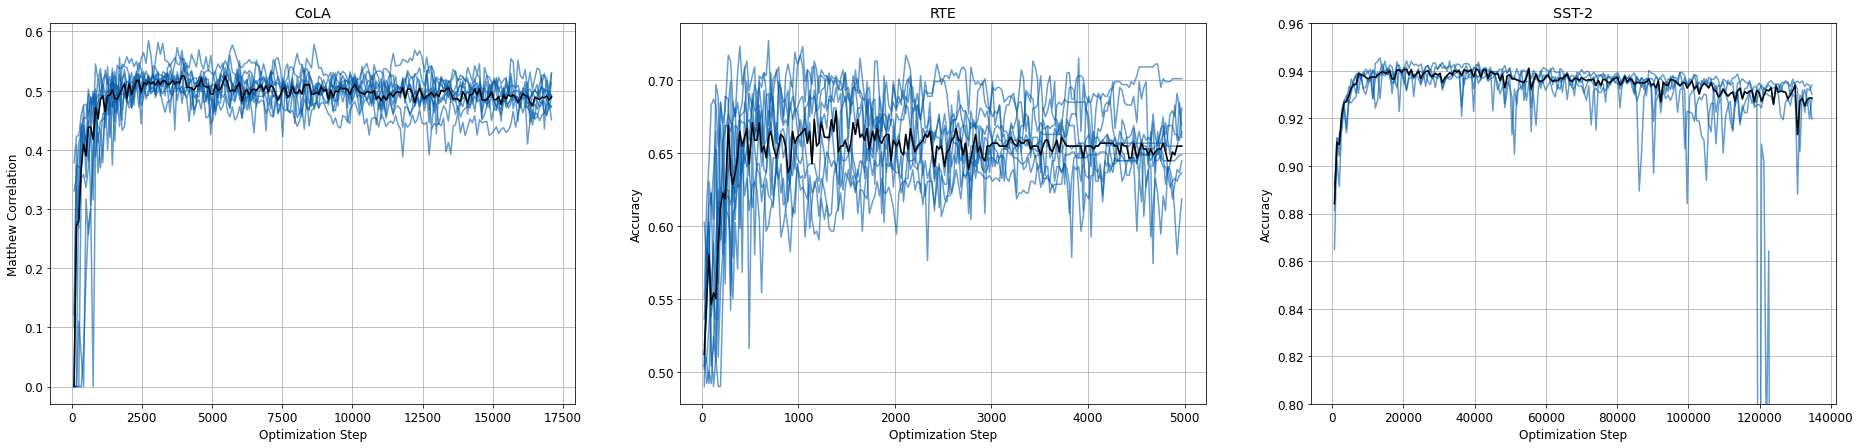

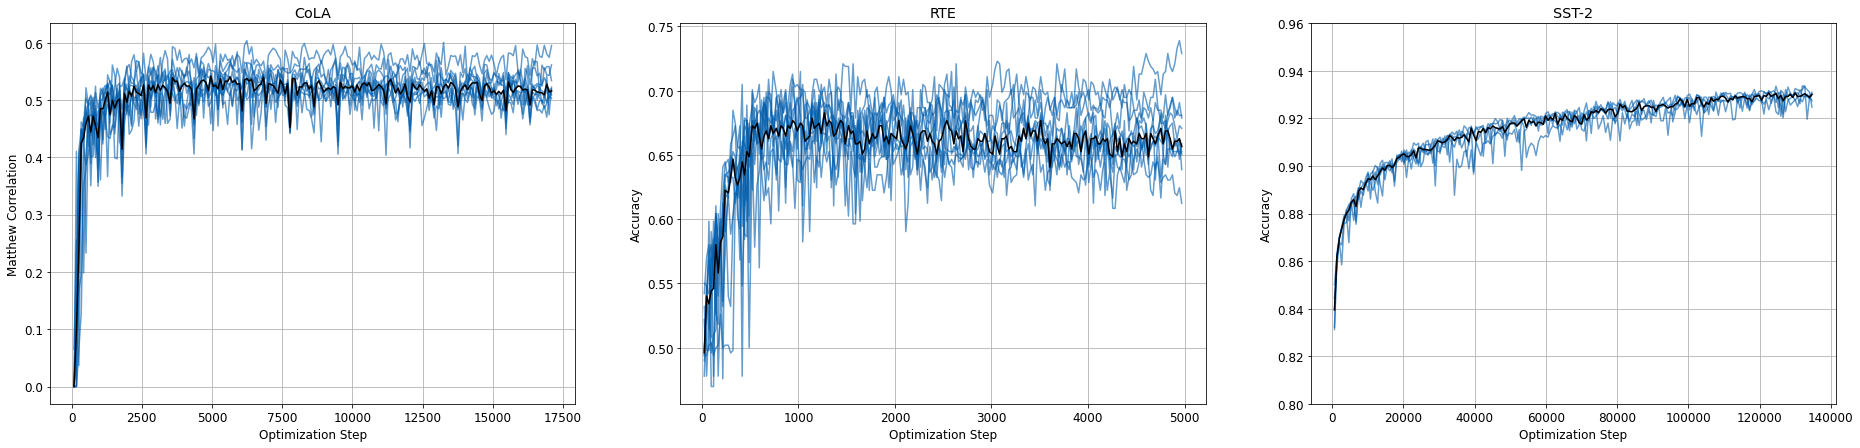

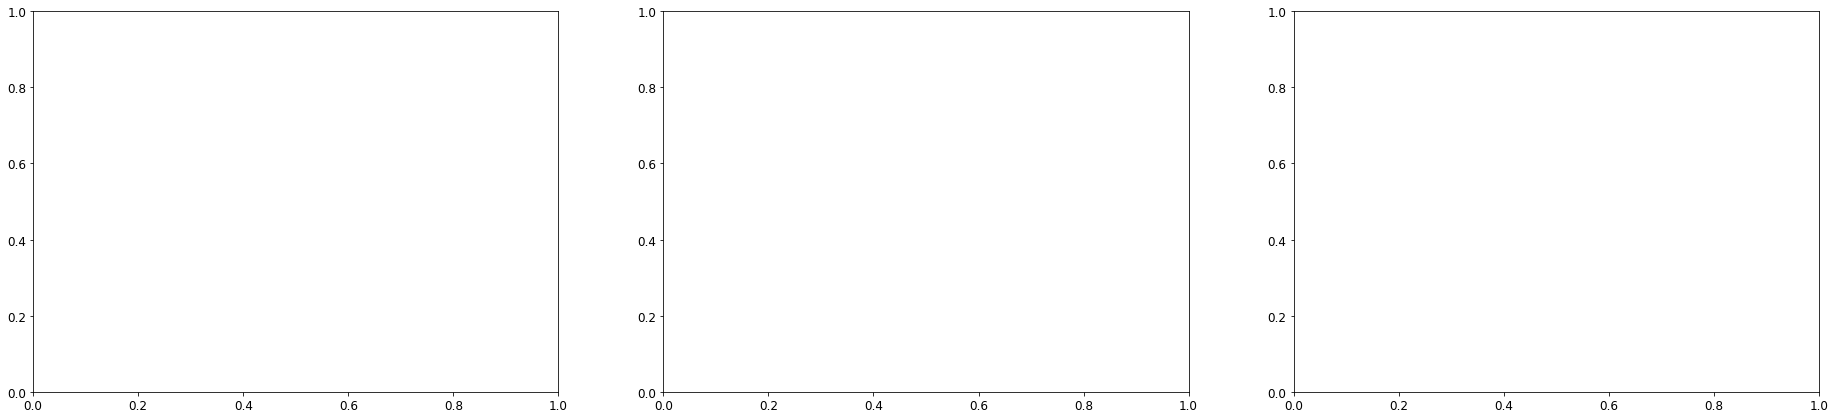

In [18]:
plt.rcParams.update({'font.size': 12})
for FT in FTS:
    fig, axs = plt.subplots(1,len(datasets), figsize = (32,7))
    for j, dataset in enumerate(datasets):
        
        ax = axs[j]
        
        df1 = df[(df['dataset_name']==dataset) & (df['Finetuning'] == FT)]
        
        if len(df1) == 0:
            continue
        
        median = torch.Tensor([get_val_metric(row) for i, row in df1.iterrows()]).median(dim = 0).values.tolist()

        for i in range(len(df1)):
            steps = str_to_list(df1.iloc[i].steps)
            validation_metric = get_val_metric(df1.iloc[i])
            ax.plot(steps, validation_metric, color = blue, alpha = 0.6)

        ax.plot(steps, median, color = 'k')
        
        #if dataset == 'CoLA':
        #    ax.annotate('x$10^3$', xy=(1.01, -0.01), ha='left', va='top', xycoords='axes fraction')
        #else:
        #    ax.annotate('x$10^3$', xy=(1.02, -0.01), ha='left', va='top', xycoords='axes fraction')
            
        ax.set_title(dataset)
        
        if dataset == 'CoLA':
            ax.set_ylabel('Matthew Correlation')
        elif dataset != 'CoLA':
            ax.set_ylabel('Accuracy')
        ax.set_xlabel('Optimization Step')
        if dataset == 'SST-2':
            plt.ylim([0.8, 0.96])
        
        ax.grid()
        
    #ticks = [str(int(x / 1000)) for x in plt.xticks()[0]][1:-1]
    #ticks_loc = plt.xticks()[0][1:-1]
    #plt.xticks(ticks_loc, ticks)
    
    plt.savefig('figures_slides/'+FT+'ValMetrics.png', format = 'png', bbox_inches = 'tight', dpi = 400)
    
    plt.show()

## Reinitialize all Parameters then BitFit

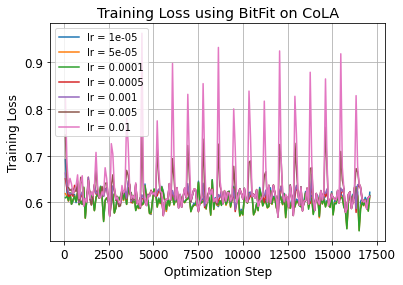

In [19]:
df = pd.read_csv('results_df.csv')
df = df[df['Finetuning']=='Init&BitFit']

lrs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]

for lr in lrs:

    sample = df[df['lr']==lr].iloc[0]
    train_loss = str_to_list(sample['train_loss'])
    steps = str_to_list(sample['steps'])

    plt.plot(steps, train_loss, label = f"lr = {lr}")

plt.xlabel("Optimization Step")
plt.ylabel("Training Loss")
plt.legend(loc = 'best', fontsize = 10)
plt.grid()
plt.title("Training Loss using BitFit on CoLA")

plt.savefig('figures_slides/Init_BiasLosses.png', format = 'png', bbox_inches = 'tight', dpi = 400)
plt.show()

# Appendix - Huge Figures

## Validation metrics + Losses

In [20]:
df = pd.read_csv('results_df.csv')

df = df[df['subsample_train_size']=='All']

datasets = ['CoLA', 'RTE', 'SST-2', 'QNLI']

FTS = ['Full', 'BitFit', 'LayerNorm', 'Random', 'InitBias&BitFit']

BitFit_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 1e-4,
    'QNLI': 5e-4
}

Random_lrs = {
    'CoLA': 1e-3,
    'RTE': 5e-3,
    'SST-2': 1e-3
}

LayerNorm_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 5e-4,
    'QNLI': 5e-4
}

InitBias_BitFit_lrs = {
    'CoLA': 1e-3,
    'RTE': 1e-4,
    'SST-2': 5e-4
}

df = df[(df['dataset_name'].isin(datasets)) & (df['Finetuning'].isin(FTS))]

for dataset in datasets:
    
    if dataset in list(BitFit_lrs.keys()):

        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'BitFit') & (df['lr'] == BitFit_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'BitFit'))]
    if dataset in list(Random_lrs.keys()):  
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'Random') & (df['lr'] == Random_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'Random'))]
    if dataset in list(LayerNorm_lrs.keys()):  
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'LayerNorm') & (df['lr'] == LayerNorm_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'LayerNorm'))]
    if dataset in list(InitBias_BitFit_lrs.keys()):  
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'InitBias&BitFit') & (df['lr'] == InitBias_BitFit_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'InitBias&BitFit'))]

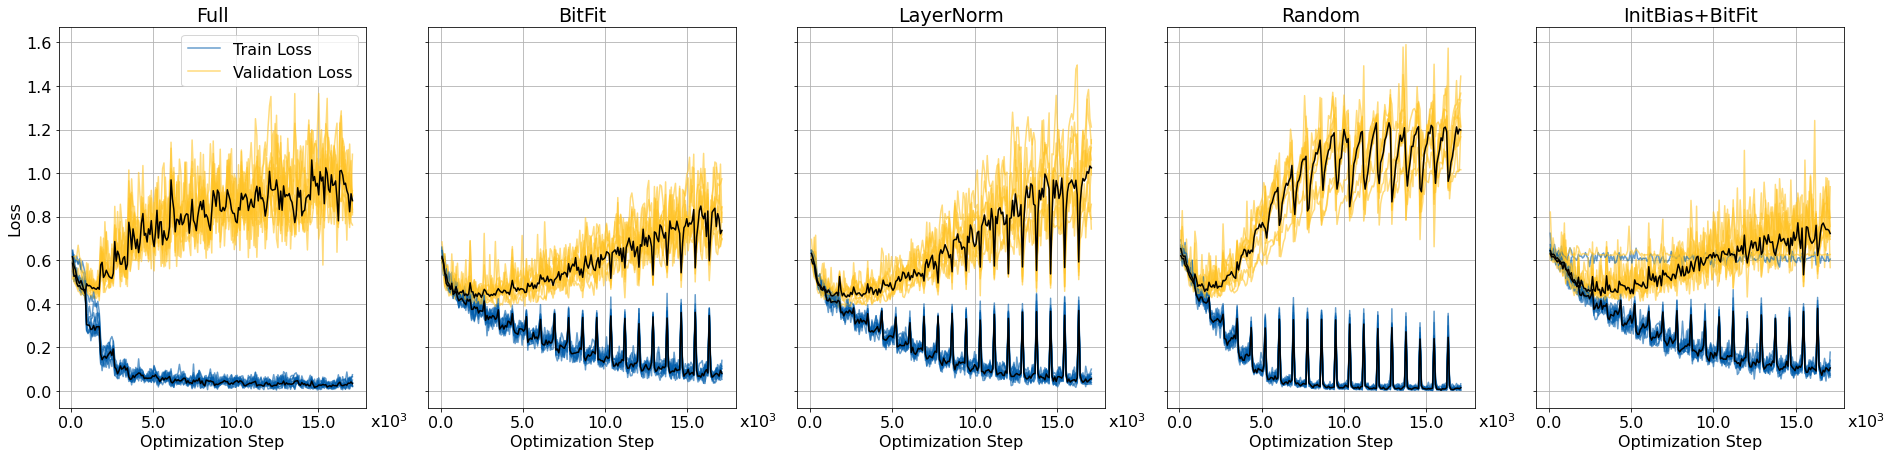

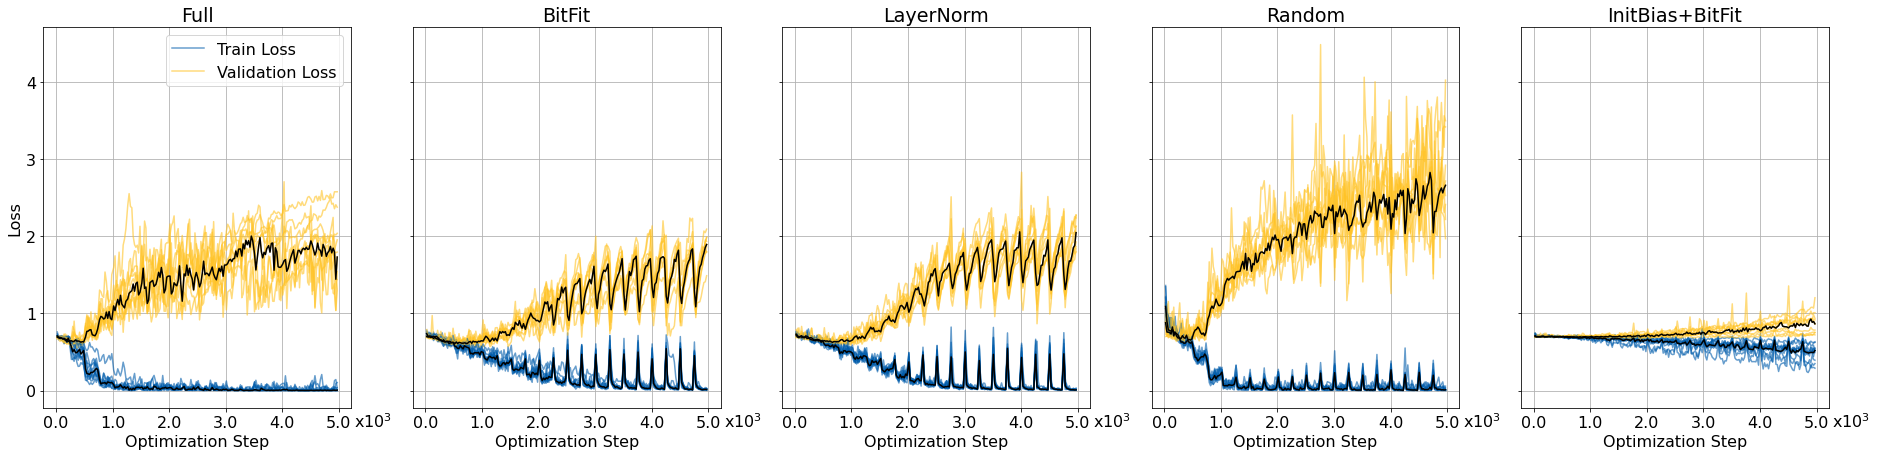

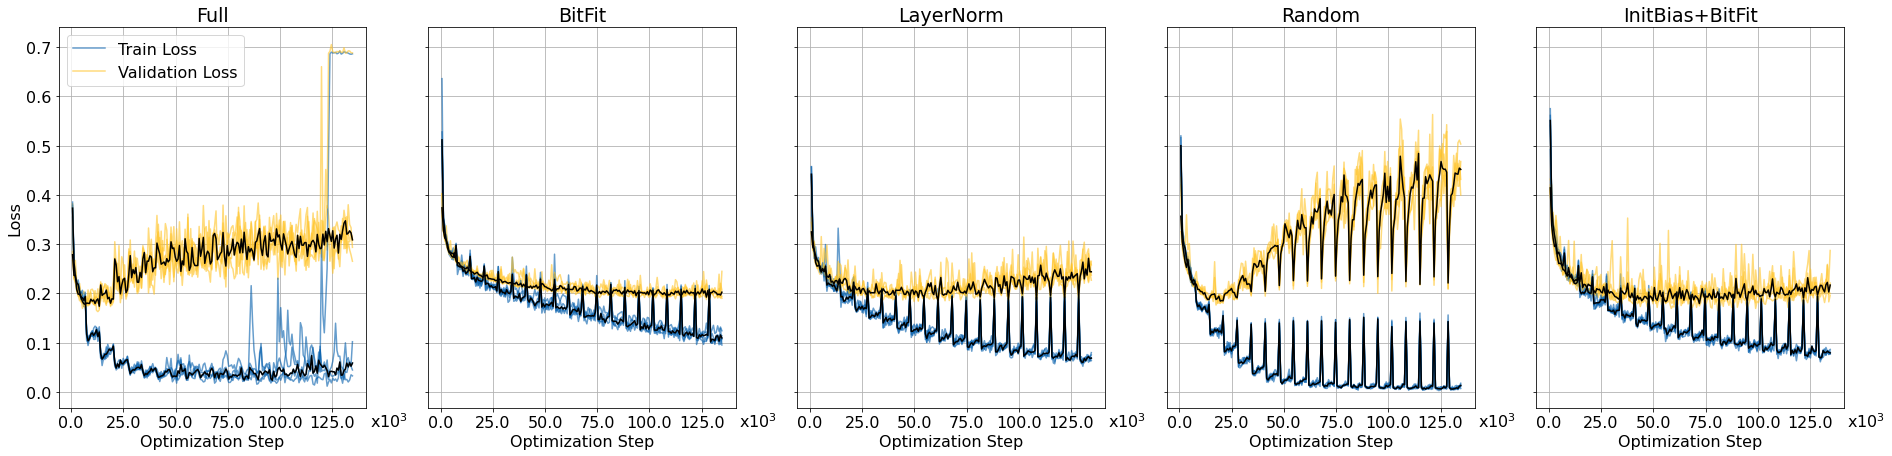

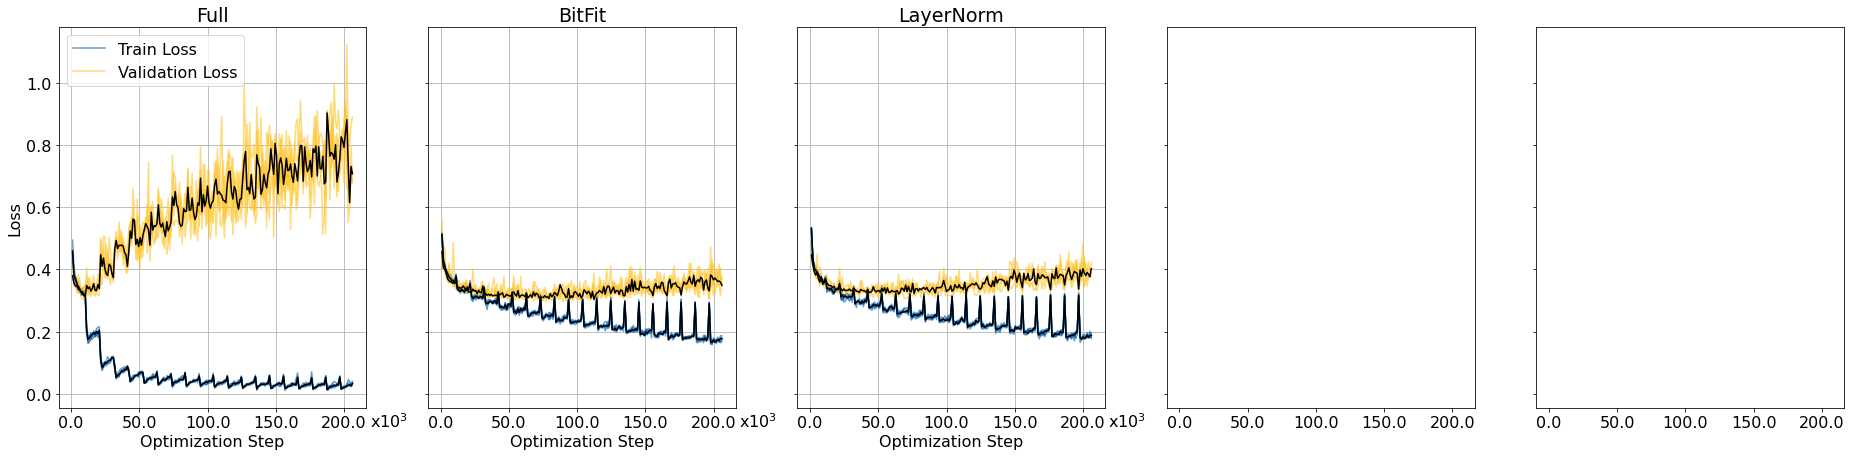

In [21]:
plt.rcParams.update({'font.size': 16})
for dataset in datasets:
    
    fig, axs = plt.subplots(1, 5, figsize = (32,7), sharey = True, sharex = True)
    
    for i, FT in enumerate(FTS):
        
        ax = axs[i]
        
        df1 = df[(df['dataset_name']==dataset) & (df['Finetuning']==FT)]
        
        if len(df1) == 0:
            continue
            
        median_train = [str_to_list(x.train_loss) for _, x in df1.iterrows()]
        median_train = torch.Tensor(median_train).median(dim = 0).values.tolist()
        median_val = [str_to_list(x.validation_loss) for _, x in df1.iterrows()]
        median_val = torch.Tensor(median_val).median(dim = 0).values.tolist()

        steps = str_to_list(df1.iloc[0]['steps'])

        for i in range(len(df1)):

            steps = str_to_list(df1.iloc[i]['steps'])
            train_loss = str_to_list(df1.iloc[i]['train_loss'])
            val_loss = str_to_list(df1.iloc[i]['validation_loss'])

            ax.plot(steps, train_loss, color = blue, alpha = 0.6)
            ax.plot(steps, val_loss, color = orange, alpha = 0.6)
            
        if FT == 'Full':
            ax.legend(['Train Loss', 'Validation Loss'])
            ax.set_ylabel('Loss')

        ax.plot(steps, median_train, color = 'k')
        ax.plot(steps, median_val, color = 'k')
        
        if FT == 'InitBias&BitFit':
            FT = FT.replace('&', '+')
        ax.set_title(FT)
        ax.set_xlabel('Optimization Step')
        ax.grid()
        
        ax.annotate('x$10^3$', xy=(1.01, -0.01), ha='left', va='top', xycoords='axes fraction')
        
    ticks = [str(x / 1000) for x in plt.xticks()[0]][1:-1]
    ticks_loc = plt.xticks()[0][1:-1]
    plt.xticks(ticks_loc, ticks)
    
    plt.savefig('figures/'+dataset+'Losses.pdf', format = 'pdf', bbox_inches = 'tight')
        
    plt.show()

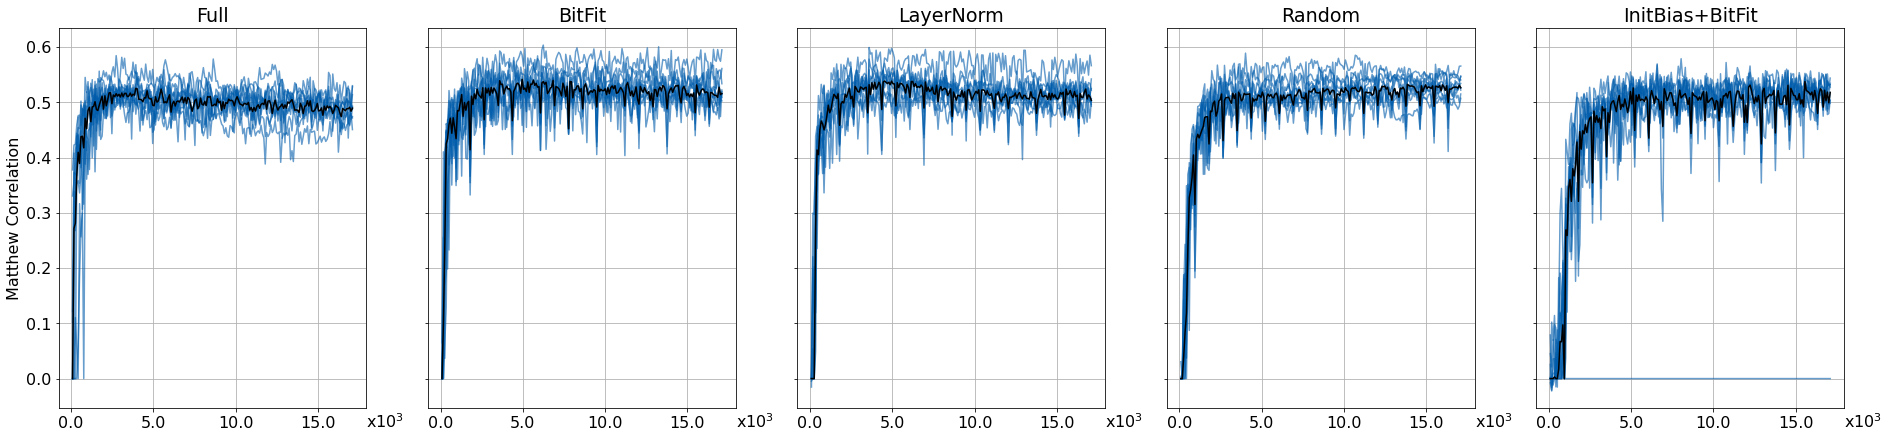

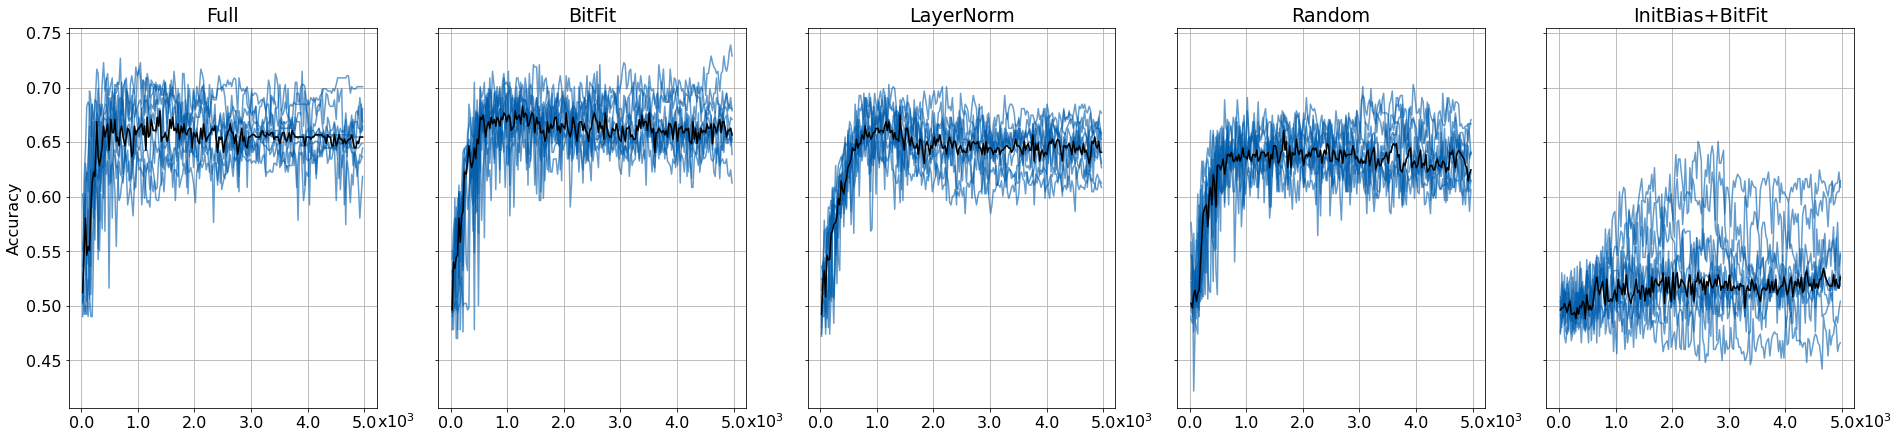

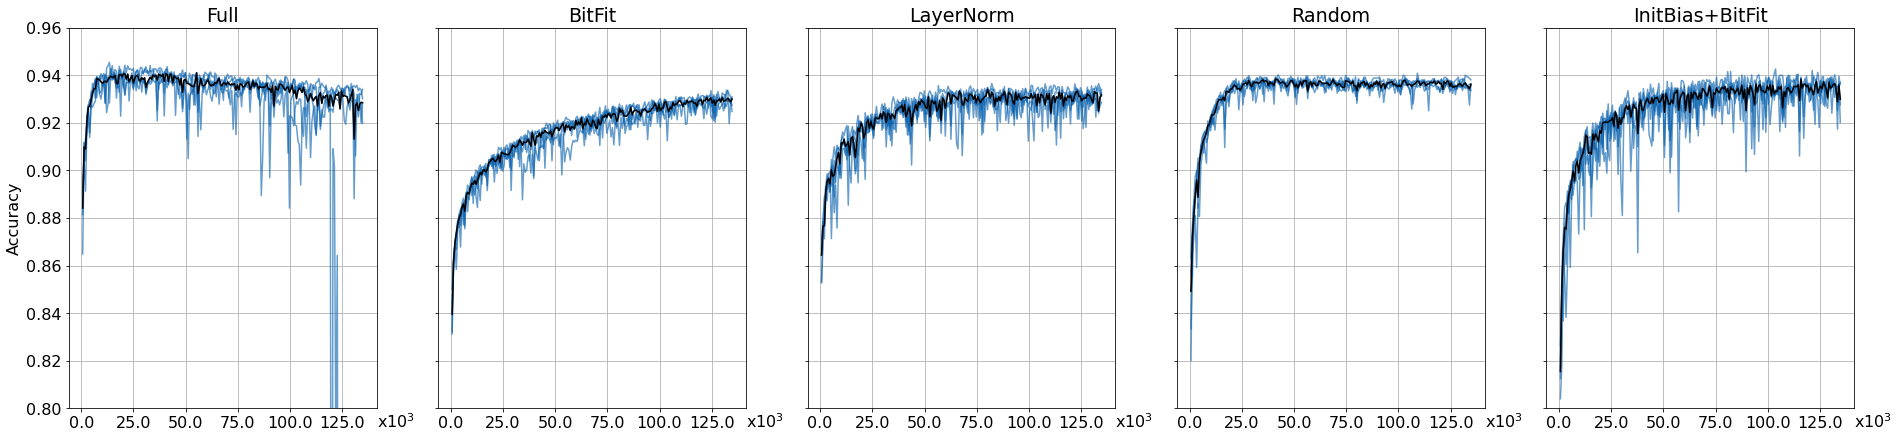

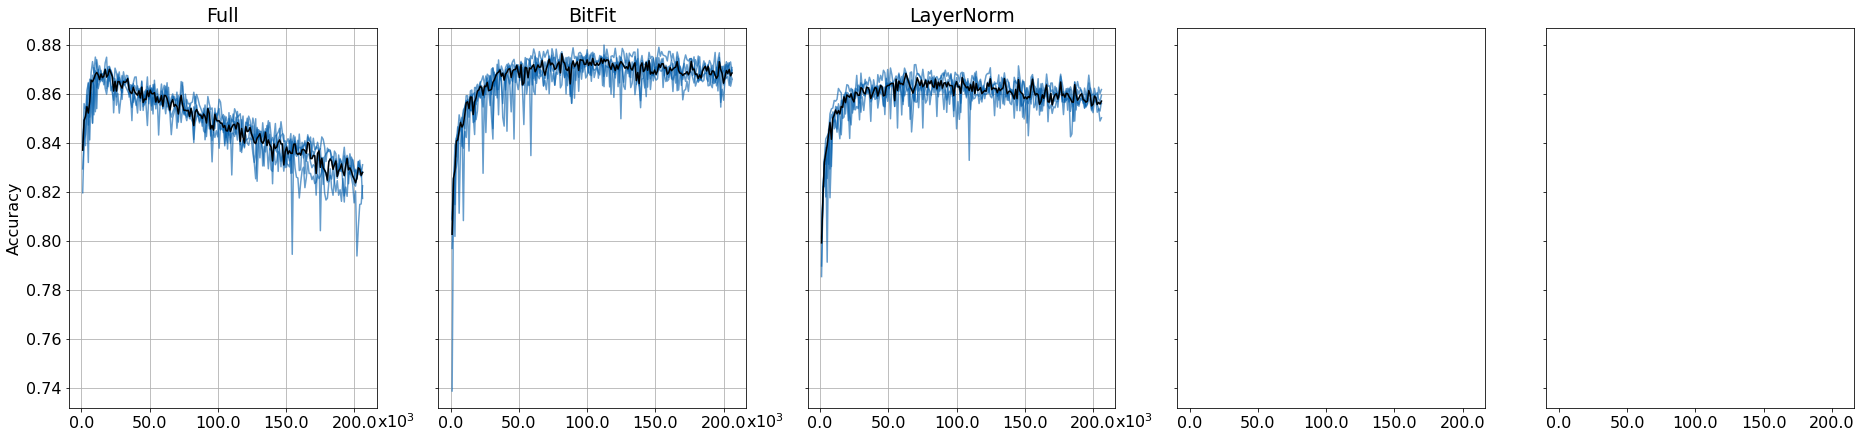

In [22]:
plt.rcParams.update({'font.size': 16})
for dataset in datasets:
    fig, axs = plt.subplots(1,5, figsize = (32,7), sharex = True, sharey = True)
    for j, FT in enumerate(FTS):
        
        ax = axs[j]
        
        df1 = df[(df['dataset_name']==dataset) & (df['Finetuning'] == FT)]
        
        if len(df1) == 0:
            continue
        
        median = torch.Tensor([get_val_metric(row) for i, row in df1.iterrows()]).median(dim = 0).values.tolist()

        for i in range(len(df1)):
            steps = str_to_list(df1.iloc[i].steps)
            validation_metric = get_val_metric(df1.iloc[i])
            ax.plot(steps, validation_metric, color = blue, alpha = 0.6)

        ax.plot(steps, median, color = 'k')
            
        ax.annotate('x$10^3$', xy=(1, -0.01), ha='left', va='top', xycoords='axes fraction')
        
        if FT == 'InitBias&BitFit':
            FT = FT.replace('&', '+')
        ax.set_title(FT)
        
        if dataset == 'CoLA' and FT == 'Full':
            ax.set_ylabel('Matthew Correlation')
        elif dataset != 'CoLA' and FT == 'Full':
            ax.set_ylabel('Accuracy')
            
        if dataset == 'SST-2':
            plt.ylim([0.8, 0.96])
        
        ax.grid()
        
    ticks = [str(x / 1000) for x in plt.xticks()[0]][1:-1]
    ticks_loc = plt.xticks()[0][1:-1]
    plt.xticks(ticks_loc, ticks)
    
    plt.savefig('figures/'+dataset+'ValMetrics.pdf', format = 'pdf', bbox_inches = 'tight')
    
    plt.show()

# SECTION 4 - BitFit and Less Data

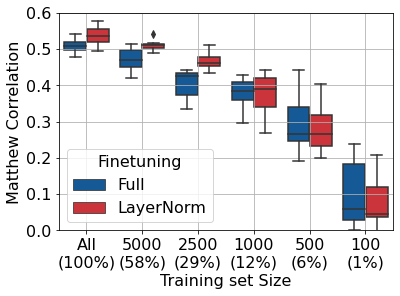

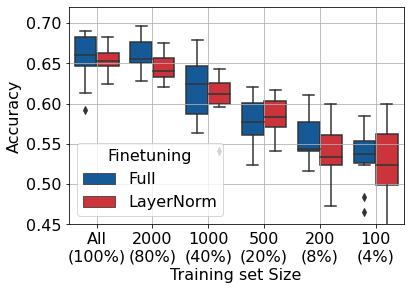

In [23]:
df = pd.read_csv('results_df.csv')

BitFit_lr = 5e-4

boxplot = True
    
for dataset_name, dataset_size in zip(['CoLA', 'RTE'], [8551, 2490]):
    
    if dataset_name == 'CoLA':
        ylim = [0.0, 0.6]
        metric = 'Matthew Correlation'
    else:
        ylim = [0.45, 0.72]
        metric = 'Accuracy'

    df2 = df[df['dataset_name'] == dataset_name]
    df2 = df2[(df2['Finetuning'] == 'Full') | ((df2['Finetuning'] == 'LayerNorm') & (df2['lr'] == BitFit_lr))]

    sizes = list(np.sort([int(x) for x in df2['subsample_train_size'].unique() if x != 'All']))

    ticks = [x/dataset_size for x in sizes]
    ticks = [str(num) + "\n({:.0f}%)".format(perc*100) for perc, num in zip(ticks, sizes)]
    ticks.append('All\n(100%)')
    ticks = ticks[::-1]

    sizes.append('All')
    order = [str(x) for x in sizes][::-1]

    hue_order = ['Full', 'LayerNorm']

    palette = {'Full': blue, 'LayerNorm': red}
    
    if boxplot:
        sns.boxplot(data = df2, x = 'subsample_train_size', y = 'eval_metric', hue = 'Finetuning',
                    order = order, hue_order = hue_order, palette = palette)
    else:
        sns.barplot(data = df2, x = 'subsample_train_size', y = 'eval_metric', hue = 'Finetuning',
                    order = order, hue_order = hue_order, palette=palette)
        
    plt.grid()
    #plt.title(dataset_name)
    plt.xlabel('Training set Size')
    plt.ylabel(metric)
    plt.ylim(ylim)
    plt.xticks([0,1,2,3,4,5], ticks)

    plt.savefig('figures/'+'DiffSize' + dataset_name + '.pdf', format = 'pdf', bbox_inches = 'tight')

    plt.show()

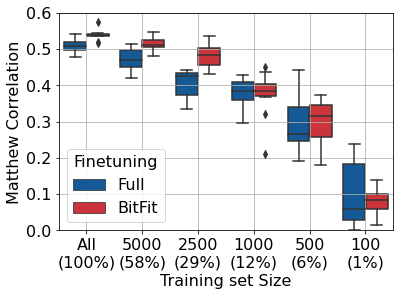

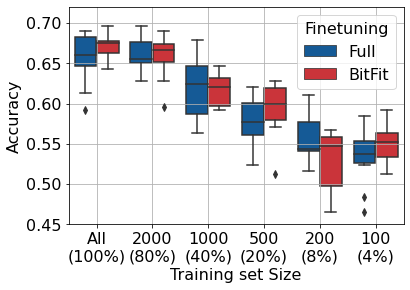

In [24]:
df = pd.read_csv('results_df.csv')

BitFit_lr = 5e-4

boxplot = True
    
for dataset_name, dataset_size in zip(['CoLA', 'RTE'], [8551, 2490]):
    
    if dataset_name == 'CoLA':
        ylim = [0.0, 0.6]
        metric = 'Matthew Correlation'
    else:
        ylim = [0.45, 0.72]
        metric = 'Accuracy'

    df2 = df[df['dataset_name'] == dataset_name]
    df2 = df2[(df2['Finetuning'] == 'Full') | ((df2['Finetuning'] == 'BitFit') & (df2['lr'] == BitFit_lr))]

    sizes = list(np.sort([int(x) for x in df2['subsample_train_size'].unique() if x != 'All']))

    ticks = [x/dataset_size for x in sizes]
    ticks = [str(num) + "\n({:.0f}%)".format(perc*100) for perc, num in zip(ticks, sizes)]
    ticks.append('All\n(100%)')
    ticks = ticks[::-1]

    sizes.append('All')
    order = [str(x) for x in sizes][::-1]

    hue_order = ['Full', 'BitFit']

    palette = {'Full': blue, 'BitFit': red}
    
    if boxplot:
        sns.boxplot(data = df2, x = 'subsample_train_size', y = 'eval_metric', hue = 'Finetuning',
                    order = order, hue_order = hue_order, palette = palette)
    else:
        sns.barplot(data = df2, x = 'subsample_train_size', y = 'eval_metric', hue = 'Finetuning',
                    order = order, hue_order = hue_order, palette=palette)
        
    plt.grid()
    #plt.title(dataset_name)
    plt.xlabel('Training set Size')
    plt.ylabel(metric)
    plt.ylim(ylim)
    plt.xticks([0,1,2,3,4,5], ticks)

    plt.savefig('figures/'+'DiffSize' + dataset_name + '.pdf', format = 'pdf', bbox_inches = 'tight')

    plt.show()

# Section 5 - Comparison with LayerNorm

## 1 - show results

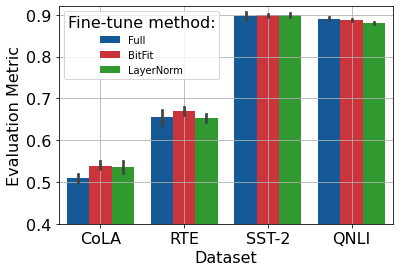

In [25]:
df = pd.read_csv('results_df.csv')

datasets = ['CoLA', 'RTE', 'SST-2', 'QNLI']
FTs = ['Full', 'BitFit', 'LayerNorm']

BitFit_lrs = {'CoLA': 5e-4,
             'RTE': 5e-4,
             'SST-2': 1e-4,
             'QNLI': 5e-4}

LayerNorm_lrs = {'CoLA': 5e-4,
                'RTE': 5e-4,
                'SST-2': 5e-4,
                'QNLI': 5e-4}

dfset = df[(df['dataset_name'].isin(datasets)) & (df['subsample_train_size']=='All')]
dfset = dfset[dfset['Finetuning'].isin(FTs)]

palette = {'Full': blue, 'BitFit': red, 'LayerNorm': green}

for dataset in datasets:
    
    dfset = dfset[((dfset['dataset_name'] == dataset) & (dfset['lr'] == BitFit_lrs[dataset]) & (dfset['Finetuning'] == 'BitFit')) |
                  ((dfset['dataset_name'] != dataset) | (dfset['Finetuning'] != 'BitFit'))]
    
    dfset = dfset[((dfset['dataset_name'] == dataset) & (dfset['lr'] == LayerNorm_lrs[dataset]) & (dfset['Finetuning'] == 'LayerNorm')) |
                  ((dfset['dataset_name'] != dataset) | (dfset['Finetuning'] != 'LayerNorm'))]

hue_order = ['Full', 'BitFit', 'LayerNorm']
order = datasets

sns.barplot(data = dfset, x = 'dataset_name', y = 'eval_metric', hue = 'Finetuning',
            order = order, hue_order = hue_order, palette = palette)
plt.xlabel('Dataset')
plt.ylabel('Evaluation Metric')
plt.legend(loc = 'best', title = 'Fine-tune method:', fontsize = 10)
plt.ylim([0.4, 0.92])
plt.grid()

plt.savefig('figures/LayerNormBarplots.pdf')

plt.show()



## 2 - Show losses

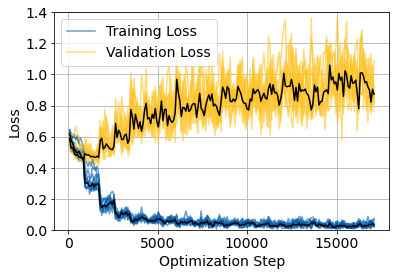

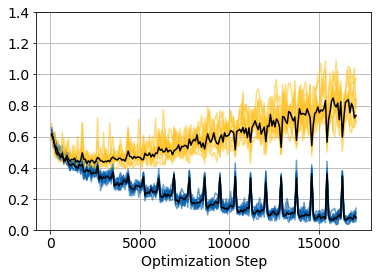

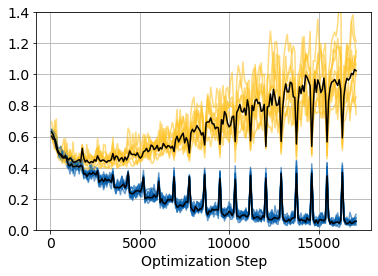

In [26]:
plt.rcParams.update({'font.size': 14})

df1 = dfset[(dfset['dataset_name'] == 'CoLA') & (dfset['Finetuning'] == 'Full')]

median_train = [str_to_list(x.train_loss) for _, x in df1.iterrows()]
median_train = torch.Tensor(median_train).median(dim = 0).values.tolist()
median_val = [str_to_list(x.validation_loss) for _, x in df1.iterrows()]
median_val = torch.Tensor(median_val).median(dim = 0).values.tolist()

steps = str_to_list(df1.iloc[0]['steps'])

for i in range(len(df1)):
    
    steps = str_to_list(df1.iloc[i]['steps'])
    train_loss = str_to_list(df1.iloc[i]['train_loss'])
    val_loss = str_to_list(df1.iloc[i]['validation_loss'])
    
    plt.plot(steps, train_loss, color = blue, alpha = 0.6)
    plt.plot(steps, val_loss, color = orange, alpha = 0.6)
    
plt.legend(['Training Loss', 'Validation Loss'], loc = 'upper left')
    
plt.plot(steps, median_train, color = 'k')
plt.plot(steps, median_val, color = 'k')

plt.xlabel('Optimization Step')
plt.ylabel('Loss')
plt.ylim([0.0, 1.4])
plt.grid()

plt.savefig('figures/FullCoLALoss.pdf', format = 'pdf', bbox_inches = 'tight')
    
plt.show()

####################################################################################

df1 = dfset[(dfset['dataset_name'] == 'CoLA') & (dfset['Finetuning'] == 'BitFit')]

median_train = [str_to_list(x.train_loss) for _, x in df1.iterrows()]
median_train = torch.Tensor(median_train).median(dim = 0).values.tolist()
median_val = [str_to_list(x.validation_loss) for _, x in df1.iterrows()]
median_val = torch.Tensor(median_val).median(dim = 0).values.tolist()

steps = str_to_list(df1.iloc[0]['steps'])

for i in range(len(df1)):
    
    train_loss = str_to_list(df1.iloc[i]['train_loss'])
    val_loss = str_to_list(df1.iloc[i]['validation_loss'])
    
    plt.plot(steps, train_loss, color = blue, alpha = 0.6)
    plt.plot(steps, val_loss, color = orange, alpha = 0.6)
    
plt.plot(steps, median_train, color = 'k')
plt.plot(steps, median_val, color = 'k')

plt.xlabel('Optimization Step')
plt.ylim([0.0, 1.4])
plt.grid()

plt.savefig('figures/BitFitCoLALoss.pdf', format = 'pdf', bbox_inches = 'tight')

plt.show()

####################################################################################

df1 = dfset[(dfset['dataset_name'] == 'CoLA') & (dfset['Finetuning'] == 'LayerNorm')]

median_train = [str_to_list(x.train_loss) for _, x in df1.iterrows()]
median_train = torch.Tensor(median_train).median(dim = 0).values.tolist()
median_val = [str_to_list(x.validation_loss) for _, x in df1.iterrows()]
median_val = torch.Tensor(median_val).median(dim = 0).values.tolist()

steps = str_to_list(df1.iloc[0]['steps'])

for i in range(len(df1)):
    
    steps = str_to_list(df1.iloc[i]['steps'])
    train_loss = str_to_list(df1.iloc[i]['train_loss'])
    val_loss = str_to_list(df1.iloc[i]['validation_loss'])
    
    plt.plot(steps, train_loss, color = blue, alpha = 0.6)
    plt.plot(steps, val_loss, color = orange, alpha = 0.6)
    
plt.plot(steps, median_train, color = 'k')
plt.plot(steps, median_val, color = 'k')

plt.xlabel('Optimization Step')
plt.ylim([0.0, 1.4])
plt.grid()

plt.savefig('figures/LayerNormCoLALoss.pdf', format = 'pdf', bbox_inches = 'tight')

plt.show()

# 6 - Random Fine-tuning

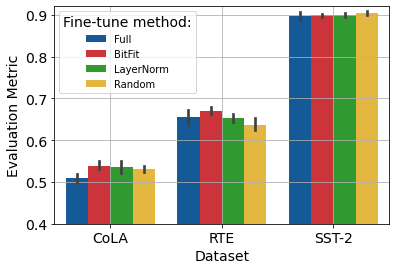

In [27]:
df = pd.read_csv('results_df.csv')

df = df[df['subsample_train_size']=='All']

datasets = ['CoLA', 'RTE', 'SST-2']

FTS = ['Full', 'BitFit', 'LayerNorm', 'Random']

BitFit_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 1e-4
}

Random_lrs = {
    'CoLA': 1e-3,
    'RTE': 5e-3,
    'SST-2': 1e-3
}

LayerNorm_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 5e-4
}

df = df[(df['dataset_name'].isin(datasets)) & (df['Finetuning'].isin(FTS))]

for dataset in datasets:
    
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'BitFit') & (df['lr'] == BitFit_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'BitFit'))]
        
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'Random') & (df['lr'] == Random_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'Random'))]
        
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'LayerNorm') & (df['lr'] == LayerNorm_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'LayerNorm'))]

palette = {'Full': blue,
          'BitFit': red,
          'LayerNorm': green,
          'Random': orange}

order = datasets
hue_order = FTS

sns.barplot(data = df, x = 'dataset_name', y = 'eval_metric', hue = 'Finetuning',
           order = order, hue_order = hue_order, palette = palette)
plt.xlabel('Dataset')
plt.ylabel('Evaluation Metric')
plt.ylim([0.4, 0.92])
plt.grid()
plt.legend(loc = 'best', title = 'Fine-tune method:', fontsize = 10)

plt.savefig('figures/RandomBarplot.pdf', format = 'pdf', bbox_inches = 'tight')

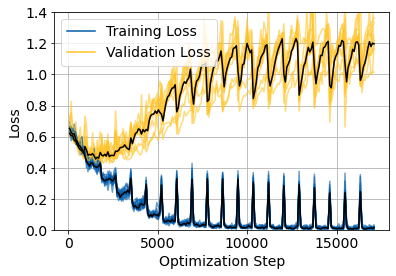

In [28]:
df1 = df[(df['dataset_name']=='CoLA') & (df['Finetuning'] == 'Random')]

median_train = [str_to_list(x.train_loss) for _, x in df1.iterrows()]
median_train = torch.Tensor(median_train).median(dim = 0).values.tolist()
median_val = [str_to_list(x.validation_loss) for _, x in df1.iterrows()]
median_val = torch.Tensor(median_val).median(dim = 0).values.tolist()

steps = str_to_list(df1.iloc[0]['steps'])

plt.plot(steps, median_train, color = blue, alpha = 1)
plt.plot(steps, median_val, color = orange, alpha = 1)
plt.legend(['Training Loss', 'Validation Loss'], loc = 'upper left')

for i in range(len(df1)):
    
    steps = str_to_list(df1.iloc[i]['steps'])
    train_loss = str_to_list(df1.iloc[i]['train_loss'])
    val_loss = str_to_list(df1.iloc[i]['validation_loss'])
    
    plt.plot(steps, train_loss, color = blue, alpha = 0.6)
    plt.plot(steps, val_loss, color = orange, alpha = 0.6)
    
plt.plot(steps, median_train, color = 'k')
plt.plot(steps, median_val, color = 'k')

plt.legend(['Training Loss', 'Validation Loss'], loc = 'upper left')

plt.xlabel('Optimization Step')
plt.ylabel('Loss')
plt.ylim([0.0, 1.4])
plt.grid()

plt.savefig('figures/RandomCoLALoss.pdf', format = 'pdf', bbox_inches = 'tight')

# Reinitialization

Init_BitFit can not learn, SEE EXTRACTRESULTS

IniBias&BitFit Results

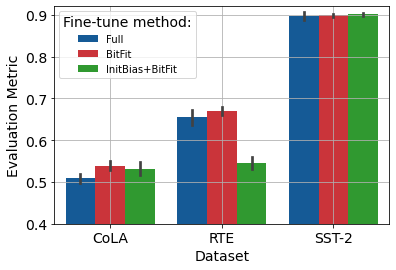

In [29]:
df = pd.read_csv('results_df.csv')

df = df[df['subsample_train_size']=='All']

datasets = ['CoLA', 'RTE', 'SST-2']

FTS = ['Full', 'BitFit', 'InitBias&BitFit']

BitFit_lrs = {
    'CoLA': 5e-4,
    'RTE': 5e-4,
    'SST-2': 1e-4
}

InitBias_BitFit_lrs = {
    'CoLA': 1e-3,
    'RTE': 1e-4,
    'SST-2': 5e-4
}

df = df[(df['dataset_name'].isin(datasets)) & (df['Finetuning'].isin(FTS))]

for dataset in datasets:
    
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'BitFit') & (df['lr'] == BitFit_lrs[dataset])) |
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'BitFit'))]
    
        df = df[((df['dataset_name'] == dataset) & (df['Finetuning'] == 'InitBias&BitFit') & (df['lr'] == InitBias_BitFit_lrs[dataset])  &
                (df['eval_metric']>0.1) )|
               ((df['dataset_name'] != dataset) | (df['Finetuning'] != 'InitBias&BitFit'))]

palette = {'Full': blue,
          'BitFit': red,
          'InitBias+BitFit': green}

order = datasets
hue_order = FTS
hue_order[2] = 'InitBias+BitFit'

df['Finetuning'] = df['Finetuning'].apply(lambda x: x.replace('&', '+'))

sns.barplot(data = df, x = 'dataset_name', y = 'eval_metric', hue = 'Finetuning',
           order = order, hue_order = hue_order, palette = palette)
plt.xlabel('Dataset')
plt.ylabel('Evaluation Metric')
plt.ylim([0.4, 0.92])
plt.grid()
plt.legend(loc = 'best', title = 'Fine-tune method:', fontsize = 10)

plt.savefig('figures/InitBiasBarPlot.pdf', format = 'pdf', bbox_inches = 'tight')

## Reintialize all Parameters then BitFit

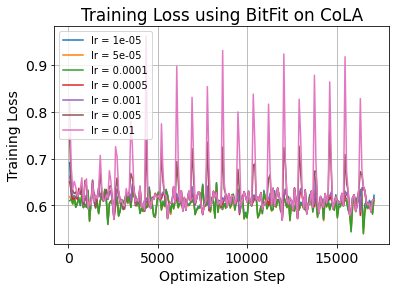

In [30]:
df = pd.read_csv('results_df.csv')
df = df[df['Finetuning']=='Init&BitFit']

lrs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]

for lr in lrs:

    sample = df[df['lr']==lr].iloc[0]
    train_loss = str_to_list(sample['train_loss'])
    steps = str_to_list(sample['steps'])

    plt.plot(steps, train_loss, label = f"lr = {lr}")

plt.xlabel("Optimization Step")
plt.ylabel("Training Loss")
plt.legend(loc = 'best', fontsize = 10)
plt.grid()
plt.title("Training Loss using BitFit on CoLA")

plt.savefig('figures/Init_BiasLosses.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()